출처: [https://www.kaggle.com/code/willkoehrsen/automated-feature-engineering-basics/notebook](https://www.kaggle.com/code/willkoehrsen/automated-feature-engineering-basics/notebook)

# Introduction: Automated Feature Engineering Basics
이 노트북에서는 [featuretools](https://featuretools.alteryx.com/en/stable/) 라이브러리를 사용하여 Home Credit Default Risk 데이터 세트에 automated feature engineering을 적용하는 방법을 안내합니다. Featuretools는 structured, related 데이터의 여러 테이블에서 새 feature을 자동으로 생성하기 위한 오픈 소스 Python 패키지입니다. training을 위해 하나의 데이터 프레임으로 합쳐야 하는 여러 관련 테이블이 있는 Home Credit Default Risk competition과 같은 문제에 이상적인 도구입니다.

## Feature Engineering
[feature engineering](https://en.wikipedia.org/wiki/Feature_engineering)의 목적은 하나의 테이블에 전체 데이터 세트의 많은 정보를 나타내는 새로운 feature(explanatory variables 또는 predictors라고도 함)을 만드는 것입니다. 일반적으로 이 프로세스는 ```groupby```, ```agg``` 또는 ```merge```와 같은 pandas 작업을 사용하여 수동으로 수행되며 매우 지루할 수 있습니다.
게다가, manual feature engineering은 인간의 시간 제약과 상상력에 의해 제한됩니다. 우리는 유용할 모든 가능한 feature을 생각해낼 수 없습니다. (manual feature engineering을 사용하는 예는 이 competitioni에 적용한 [part one](https://www.kaggle.com/code/jundthird/introduction-manual-feature-engineering)과 [part two](https://www.kaggle.com/code/jundthird/manual-feature-engineering-pt2)를 확인하세요) 머신 러닝 모델은 우리가 제공하는 데이터에서만 학습할 수 있기 때문에 적절한 feature을 생성하는 것의 중요성은 아무리 강조해도 지나치지 않습니다. 사용 가능한 데이터 세트에서 최대한 많은 정보를 추출하는 것은 효과적인 솔루션을 만드는 데 중요합니다.

[Automated feature engineering](https://choisk7.github.io/ml/Automated_Feature_Engineering_in_Python/)은 데이터 세트에서 수백 또는 수천 개의 새로운 feature을 자동으로 구축하여 feature 생성 문제를 해결하여 data scientist를 돕는 것을 목표로 합니다. 현재로서는 automated feature engineering을 위한 유일한 라이브러리인 Featuretools는 data scientist를 대체하지 않지만 강력한 모델을 production에 제공하는 것과 같은 machine learning pipeline의 더 중요한 부분에 집중할 수 있습니다.

여기에서는 featuretools를 사용한 automated feature engineering의 개념에 대해 설명하고 Home Credit Default Risk competition에서 이를 구현하는 방법을 보여줍니다. 여기서는 기본 사항을 고수하여 아이디어를 얻은 다음 나중에 featuretools를 커스터마이징할 때, 이 토대를 구축할 것입니다. 이 작업은 Kaggle 커널의 능력 범위을 벗어나는 계산이 많이 필요한 작업이기 때문에 데이터의 subset으로 작업합니다. 이 노트북에서는 위의 작업을 수행하고 [전체 데이터 세트로 부터 얻은 결과](https://www.kaggle.com/datasets/willkoehrsen/home-credit-default-risk-feature-tools)를 통해 methods를 수행했습니다. 이 노트북의 끝에서 우리는 feature 자체와 수동 설계한 feature과 자동으로 구축된 feature의 다양한 조합으로 모델링한 결과를 살펴볼 것입니다.

만약 이 competition이 처음이라면, [이 노트북](https://www.kaggle.com/code/jundthird/start-here-a-gentle-introduction)을 먼저 보는 것을 추천합니다.

In [1]:
# !pip install featuretools

In [2]:
import pandas as pd
import numpy as np
import featuretools as ft
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 22
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Problem
The Home Credit Default Risk competition은 supervised classification machine learning task입니다. 목표는 과거 재정 및 사회경제적 데이터를 사용하여 신청자가 대출을 상환할 수 있는지 여부를 예측하는 것입니다. 이것은 standard supervised classificatdion tast입니다.

## Dataset
데이터는 은행이 없는 인구에게 제공되는 신용 한도(대출) 전용 서비스인 Home Credit에서 제공합니다.

7개의 데이터가 있습니다:

- **application_train/application_test**: 각 대출 신청 정보가 담겨 있는 메인 train, test 데이터. 모든 대출건은 각각 자기의 행을 가지고 있고 ```SK_ID_CURR``` feature에 의해 식별됩니다. ```TARGET``` 값의 0은 상환되었다는 의미이고, 1은 아직 상환되지 않았다는 의미입니다.


- **bureau**: 다른 금융 기관에서의 고객들의 이전 신용에 관한 데이터. 각 이전 신용은 bureau에서 자기의 행을 가지고 있지만, 신청 데이터에 관한 하나의 대출은 여러개의 이전 신용 정보들을 가지고 있을 수 있습니다.


- **bureau_balance**: bureau에서의 이전 신용 정보에 대한 월간 데이터. 각 행은 이전 신용 정보의 한달치이며, 이전 신용정보는 신용기간이 만료되는 각 월에 대한 여러개의 행을 가질 수 있다.


- **previous_application**: 신청 데이터에서 대출이 있는 고객들의 Home Credit에서의 이전 대출 신청 정보. 신청 데이터에서의 각 현재 대출 정보는 여러개의 이전 대출 정보를 가질 수 있다. 각각의 이전 신청 정보는 한 행을 가지고 ```SK_ID_PREV``` feature을 통해 식별된다.


- **POS_CASH_BALANCE**: 고객들이 Home Credit을 통해 가지고 있던 이전 판매 시점 혹은 현금 대출에 대한 월별 데이터. 각 행은 이전 판매 시점 혹은 현금 대출 정보의 한달치이며, 하나의 이전 대출 정보는 여러개의 행을 가질 수 있다.


- **credit_card_balance**: Home Credit을 통해 고객들이 가지고 있는 이전 신용 카드에 대한 월별 데이터. 각 행은 한 달 동안의 신용카드 잔액이며, 각 신용 카드는 여러개의 행을 가질 수 있습니다.


- **installments_payment**: Home Credit에서 이전 대출에 대한 지불 내역. 결제할 때 마다 행이 하나씩 있고, 결제가 누락될 때마다 행이 하나씩 있습니다.


아래 다이어그램(Home Credit 제공)은 테이블이 어떻게 관련되어 있는지 보여줍니다. 이 그림은 featuretools에서 관계를 정의해야 할 때 매우 유용합니다.

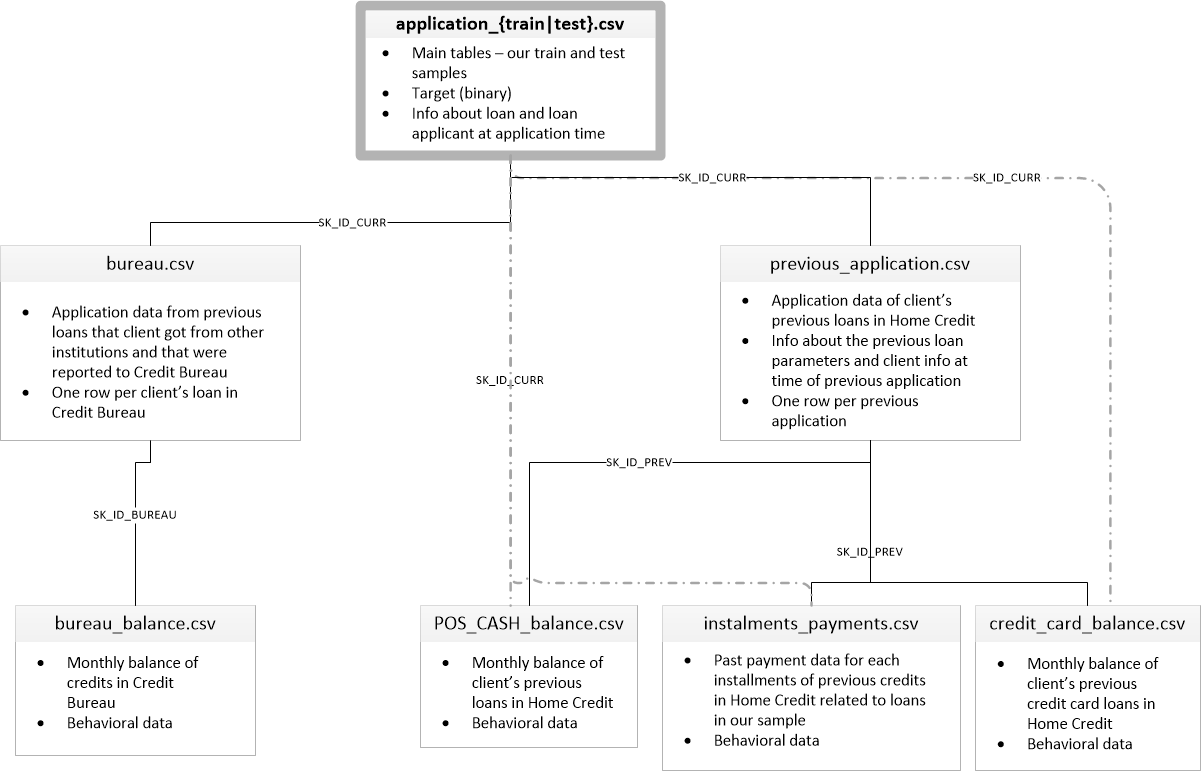

### Read in Data and Create Small Datasets
전체 데이터 세트를 읽고 ```SK_ID_CURR```로 정렬하고 처음 1000개 행만 유지하여 계산이 가능하도록 합니다. 나중에 script로 변환하고 전체 데이터 세트로 실행할 수 있습니다.

In [3]:
app_train = pd.read_csv('./home_credit/application_train.csv').sort_values('SK_ID_CURR').reset_index(drop=True).loc[:1000, :]
app_test = pd.read_csv('./home_credit/application_test.csv').sort_values('SK_ID_CURR').reset_index(drop=True).loc[:1000, :]
bureau = pd.read_csv('./home_credit/bureau.csv').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).reset_index(drop=True).loc[:1000, :]
bureau_balance = pd.read_csv('./home_credit/bureau_balance.csv').sort_values('SK_ID_BUREAU').reset_index(drop=True).loc[:1000, :]
cash = pd.read_csv('./home_credit/POS_CASH_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop=True).loc[:1000, :]
credit = pd.read_csv('./home_credit/credit_card_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop=True).loc[:1000, :]
previous = pd.read_csv('./home_credit/previous_application.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop=True).loc[:1000, :]
installments = pd.read_csv('./home_credit/installments_payments.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop=True).loc[:1000, :]

우리는 train과 test 세트를 함께 결합하지만 세트를 식별하는 별도의 열을 추가합니다. 이는 각 데이터 세트에 동일한 정확한 절차를 적용할 것이기 때문에 중요합니다. 두 데이터 세트를 함께 결합하고 단일 데이터 프레임으로 처리하는 것이 가장 안전 방법입니다.

In [4]:
app_train['set'] = 'train'
app_test['set'] = 'test'
app_test["TARGET"] = np.nan
app = app_train.append(app_test, ignore_index=True)
app.sample(10)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
676       100782     0.0         Cash loans           M            N   
136       100158     0.0         Cash loans           M            N   
1829      105735     NaN         Cash loans           F            N   
1100      100762     NaN         Cash loans           F            N   
355       100409     0.0         Cash loans           M            N   
439       100506     0.0         Cash loans           M            Y   
1968      106712     NaN         Cash loans           F            N   
197       100229     0.0         Cash loans           F            N   
1561      103870     NaN         Cash loans           F            N   
1752      105203     NaN         Cash loans           F            Y   

     FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
676                N             0          225000.0   1017000.0      29866.5   
136                N             0          180000.0    590337.0      27486.0   
1829               Y             0          112500.0    558706.5      43366.5   
1100               N             0          180000.0    225000.0      20637.0   
355                Y             0          112500.0    454500.0      23337.0   
439                Y             0          112500.0    345645.0      16240.5   
1968               N             0          103500.0    450000.0      24412.5   
197                Y             0          157500.0    544491.0      16047.0   
1561               Y             0          180000.0    547344.0      23319.0   
1752               Y             0          180000.0    582804.0      31747.5   

      ...  FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
676   ...                 0                0                0   
136   ...                 0                0                0   
1829  ...                 0                0                0   
1100  ...                 0                0                0   
355   ...                 0                0                0   
439   ...                 0                0                0   
1968  ...                 0                0                0   
197   ...                 0                0                0   
1561  ...                 0                0                0   
1752  ...                 0                0                0   

     AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
676                         0.0                       0.0   
136                         0.0                       0.0   
1829                        0.0                       0.0   
1100                        0.0                       0.0   
355                         0.0                       0.0   
439                         NaN                       NaN   
1968                        NaN                       NaN   
197                         0.0                       0.0   
1561                        0.0                       0.0   
1752                        0.0                       0.0   

     AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
676                         0.0                        1.0   
136                         0.0                        0.0   
1829                        0.0                        0.0   
1100                        0.0                        0.0   
355                         0.0                        0.0   
439                         NaN                        NaN   
1968                        NaN                        NaN   
197                         0.0                        0.0   
1561                        0.0                        0.0   
1752                        0.0                        0.0   

      AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR    set  
676                         0.0                         5.0  train  
136                         0.0                         1.0  train  
1829                        0.0            

# Featuretools Basics
Featuretools는 deep feature synthesis라는 기술을 사용하여 관련 테이블에서 feature을 자동으로 생성하기 위한 오픈 소스 Python 라이브러리입니다. machine learning의 많은 주제와 마찬가지로 automated feature engineering은 단순한 아이디어를 기반으로 구축된 복잡한 주제입니다. 이러한 아이디어를 한 번에 하나씩 살펴봄으로써 나중에 이를 최대한 활용할 수 있는 featuretools에 대한 이해를 높일 수 있습니다.

그 과정에서 다룰 몇 가지 개념이 있습니다:

- Entities and EntitySets
- Relationships between tables
- Feature primitives: aggregations and transformations
- Deep featue synthesis

# Entities and Entitysets
Entity는 단순히 테이블이거나 Pandas에서 ```dataframe```입니다. 관측치는 행에 있고 feature은 열에 있습니다. featuretools의 entity에는 elements가 중복되지 않는 고유 인덱스가 있어야 합니다. 현재 ```app```, ```bureau```, ```previous```만 고유 인덱스를 갖습니다(각각 ```SK_ID_CURR```, ```SK_ID_BUREAU```, ```SK_ID_PREV```). 다른 데이터 프레임의 경우 ```make_index=True```를 전달한 다음 인덱스 이름을 지정해야 합니다. entities는 각 항목이 고유한 시간으로 식별되는 시간 인덱스를 가질 수도 있습니다. (어떤 데이터에도 날짜나 시간이 없지만 시간 변수로 취급하는 것을 고려할 수 있는 월 또는 일 단위로 주어진 상대적 시간이 있습니다).

EntitySet은 테이블과 테이블 간의 관계 모음입니다. 이것은 자체 methods와 attributes을 가진 데이터 구조로 생각할 수 있습니다. EntitySet을 사용하면 여러 테이블을 그룹화하고 개별 테이블보다 훨씬 빠르게 조작할 수 있습니다.

먼저 모든 데이터를 추적하기 위해 clients라는 이름의 빈 entityset을 만듭니다.

In [5]:
es = ft.EntitySet(id="clients")

이제 각 entity 또는 데이터 테이블을 정의합니다. 데이터에 하나가 있으면 인덱스를 전달하고 그렇지 않으면 ```make_index=True```를 전달해야 합니다. Featuretools는 변수 유형을 자동으로 유추하지만 필요한 경우 변경할 수도 있습니다. 예를 들어, 정수로 표시되는 범주형 변수가 있는 경우 featuretools가 올바른 유형을 알도록 할 수 있습니다.

In [6]:
es = es.add_dataframe(dataframe_name="app", dataframe=app, index="SK_ID_CURR")
es = es.add_dataframe(dataframe_name="bureau", dataframe=bureau, index="SK_ID_BUREAU")
es = es.add_dataframe(dataframe_name="previous", dataframe=previous, index="SK_ID_PREV")

es = es.add_dataframe(dataframe_name="bureau_balance", dataframe=bureau_balance,
                      make_index=True, index="bureaubalance_index")
es = es.add_dataframe(dataframe_name="cash", dataframe=cash,
                      make_index=True, index="cash_index")
es = es.add_dataframe(dataframe_name="installments", dataframe=installments,
                      make_index=True, index="installments_index")
es = es.add_dataframe(dataframe_name="credit", dataframe=credit,
                      make_index=True, index="credit_index")

# Relationships
관계는 featuretools뿐만 아니라 모든 관계형 데이터베이스의 기본 개념입니다. one-to-many 관계를 생각하는 가장 좋은 방법은 부모 대 자식의 비유입니다. 부모는 한 개인이지만 여러 자녀를 가질 수 있습니다. 그런 다음 자녀는 자신의 자녀를 여러 명을 가질 수 있습니다. 상위 테이블에서 각 개인은 단일 행을 갖습니다. 상위 테이블의 각 개인은 하위 테이블에 여러 행을 가질 수 있습니다.

예를 들어 ```app``` 데이터 프레임에는 각 client(```SK_ID_CURR```)에 대해 하나의 행이 있는 반면 ```bureau``` 데이터 프레임에는 각 부모(```SK_ID_CURR```)에 대해 여러 개의 이전 대출(```SK_ID_PREV```)이 있습니다. 따라서 ```bureau``` 데이터 프레임은 ```app``` 데이터 프레임의 자식입니다. 각 대출은 ```bureau_balance```에 하나의 행이 있지만 ```bureau_balance```에는 여러 월간 기록이 있기 때문에 ```bureau``` 데이터 프레임은 ```bureau_balance```의 부모입니다.

In [7]:
print('Parent: app, Parent Variable: SK_ID_CURR\n\n', app.loc[:, ["SK_ID_CURR"]].head())
print('\nChild: bureau, Child Variable: SK_ID_CURR\n\n', bureau.iloc[10:30, :4].head())

Parent: app, Parent Variable: SK_ID_CURR

         SK_ID_CURR
100002      100002
100003      100003
100004      100004
100006      100006
100007      100007

Child: bureau, Child Variable: SK_ID_CURR

          SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY
6158905      100002       6158905        Closed      currency 1
6158906      100002       6158906        Closed      currency 1
6158907      100002       6158907        Closed      currency 1
6158908      100002       6158908        Closed      currency 1
6158909      100002       6158909        Active      currency 1


```SK_ID_CURR``` "100002"에는 부모 테이블에 하나의 행이 있고 자식 테이블에 여러 행이 있습니다.

두 테이블은 공유 변수를 통해 연결됩니다. ```app```과 ```bureau``` 데이터 프레임은 ```SK_ID_CURR``` 변수에 의해 연결되고 ```bureau``` 및 ```bureau_balance``` 데이터 프레임은 ```SK_ID_BUREAU```와 연결됩니다. 관계를 정의하는 것은 비교적 간단하며 competition에서 제공하는 다이어그램은 관계를 보는 데 도움이 됩니다. 각 관계에 대해 부모 변수와 자식 변수를 지정해야 합니다. 테이블 사이에는 총 6개의 관계가 있습니다. 아래에서 6개의 관계를 모두 지정한 다음 EntitySet에 추가합니다.

In [8]:
r_app_bureau = ft.Relationship(es, "app", "SK_ID_CURR", "bureau", "SK_ID_CURR")
r_bureau_balance = ft.Relationship(es, "bureau", "SK_ID_BUREAU", "bureau_balance",
                                   "SK_ID_BUREAU")
r_app_previous = ft.Relationship(es, "app", "SK_ID_CURR", "previous", "SK_ID_CURR")
r_previous_cash = ft.Relationship(es, "previous", "SK_ID_PREV", "cash", "SK_ID_PREV")
r_previous_installments = ft.Relationship(es, "previous", "SK_ID_PREV", "installments",
                                          "SK_ID_PREV")
r_previous_credit = ft.Relationship(es, "previous", "SK_ID_PREV", "credit",
                                    "SK_ID_PREV")

In [9]:
es = es.add_relationships([r_app_bureau, r_bureau_balance, r_app_previous,
                           r_previous_cash, r_previous_installments, r_previous_credit])

In [10]:
es

Entityset: clients
  DataFrames:
    app [Rows: 2002, Columns: 123]
    bureau [Rows: 1001, Columns: 17]
    previous [Rows: 1001, Columns: 37]
    bureau_balance [Rows: 1001, Columns: 4]
    cash [Rows: 1001, Columns: 9]
    installments [Rows: 1001, Columns: 9]
    credit [Rows: 1001, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

Slightly advanced note: 부모에서 자식으로의 다중 경로가 있는 [diamond graph](https://en.wikipedia.org/wiki/Diamond_graph)를 생성하지 않도록 주의해야 합니다. ```SK_ID_CURR```을 통해 ```app```과 ```cash```; ```SK_ID_PREV```를 통해 ```previous```와 ```cash```를; ```SK_ID_CURR```을 통해 ```app```과 ```previous```를 직접 연결하여, ```app```에서 ```cash```로의 두 가지 경로를 만들었습니다. 이로 인해 모호성이 발생하므로 대신 우리가 취해야 하는 접근 방식은 ```app```을 ```previous```을 통해 ```cash```에 연결하는 것입니다. ```SK_ID_PREV```를 사용하여 ```previous```(부모)와 ```cash```(자식) 간의 관계를 설정합니다. 그런 다음 ```SK_ID_CURR```을 사용하여 ```app```(부모)과 ```previous```(자식) 간의 관계를 설정합니다. 그러면 featuretools는 여러 primitives를 쌓아서 ```previous``` 및 ```cash``` 모두에서 파생된 ```app```의 features를 생성할 수 있습니다.

entity에서 모든 entities는 서로 관계가 있을 수 있습니다. 이론적으로 이를 통해 모든 entities에 대한 features를 계산할 수 있지만, 실제로는 training/testing에 사용되기 때문에 ```app``` 데이터 프레임에 대한 features만 계산합니다.

# Feature Primitives
feature primitive는 feature을 생성하기 위해 테이블 또는 테이블 세트에 적용하는 작업입니다. 이는 manual feature engineering에서 이미 사용했던 것처럼, 복잡한 feature을 생성하기 위해 두 테이블을 stacking하여 간단한 계산을 하는 것을 나타냅니다. featuer primitves는 두 가지 카테고리로 나뉩니다:

- **Aggregation:** 각 부모에 대한 자식 데이터를 함께 그룹화한 다음 평균, 최소값, 최대값 또는 표준 편차와 같은 통계를 계산하는 함수입니다. 예를 들어, 각 고객에 대한 최대  previous 대출 금액을 계산합니다. aggregation은 테이블 간의 관계를 사용하여 여러 테이블에서 작동합니다.

- **Transformation:** 단일 테이블의 하나 이상의 칼럼에 적용되는 작업입니다. 예를 들어, 칼럼의 절대값을 취하거나 한 테이블에서 두 칼럼 간의 차이를 찾는 것이 있습니다.

featuretools에서 사용 가능한 기본 feature primitives는 아래에서 볼 수 있습니다.

In [11]:
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives["type"] == "aggregation"].head(10)

name         type  dask_compatible  spark_compatible  \
0               any  aggregation             True             False   
1        num_unique  aggregation             True              True   
2     n_most_common  aggregation            False             False   
3   time_since_last  aggregation            False             False   
4               max  aggregation             True              True   
5             trend  aggregation            False             False   
6              mode  aggregation            False             False   
7              skew  aggregation            False             False   
8               all  aggregation             True             False   
9  avg_time_between  aggregation            False             False   

                                                                       description  \
0                                     Determines if any value is 'True' in a list.   
1                 Determines the number of distinct values, ignoring `NaN` values.   
2                                         Determines the `n` most common elements.   
3        Calculates the time elapsed since the last datetime (default in seconds).   
4                             Calculates the highest value, ignoring `NaN` values.   
5                                      Calculates the trend of a column over time.   
6                                     Determines the most commonly repeated value.   
7  Computes the extent to which a distribution differs from a normal distribution.   
8                                   Calculates if all values are 'True' in a list.   
9               Computes the average number of seconds between consecutive events.   

                                                                                          valid_inputs  \
0             <ColumnSchema (Logical Type = BooleanNullable)>, <ColumnSchema (Logical Type = Boolean)>   
1                                                        <ColumnSchema (Semantic Tags = ['category'])>   
2                                                        <ColumnSchema (Semantic Tags = ['category'])>   
3                            <ColumnSchema (Logical Type = Datetime) (Semantic Tags = ['time_index'])>   
4                                                         <ColumnSchema (Semantic Tags = ['numeric'])>   
5  <ColumnSchema (Logical Type = Datetime) (Semantic Tags = ['time_index'])>, <ColumnSchema (Semant...   
6                                                        <ColumnSchema (Semantic Tags = ['category'])>   
7                                                         <ColumnSchema (Semantic Tags = ['numeric'])>   
8             <ColumnSchema (Logical Type = BooleanNullable)>, <ColumnSchema (Logical Type = Boolean)>   
9                            <ColumnSchema (Logical Type = Datetime) (Semantic Tags = ['time_index'])>   

                                                                     return_type  
0                                        <ColumnSchema (Logical Type = Boolean)>  
1  <ColumnSchema (Logical Type = IntegerNullable) (Semantic Tags = ['numeric'])>  
2                                                                           None  
3           <ColumnSchema (Logical Type = Double) (Semantic Tags = ['numeric'])>  
4                                   <ColumnSchema (Semantic Tags = ['numeric'])>  
5                                   <ColumnSchema (Semantic Tags = ['numeric'])>  
6                                                                           None  
7                                   <ColumnSchema (Semantic Tags = ['numeric'])>  
8                                        <ColumnSchema (Logical Type = Boolean)>  
9           <ColumnSchema (Logical Type = Double) (Semantic Tags = ['numeric'])>

In [12]:
primitives[primitives['type'] == 'transform'].head(10)

name       type  dask_compatible  \
22                    diff_datetime  transform            False   
23                             isin  transform             True   
24  scalar_subtract_numeric_feature  transform             True   
25                          cum_min  transform            False   
26                          weekday  transform             True   
27                        longitude  transform            False   
28                             week  transform             True   
29          email_address_to_domain  transform            False   
30                    rolling_count  transform            False   
31                            equal  transform             True   

    spark_compatible  \
22             False   
23              True   
24              True   
25             False   
26              True   
27             False   
28              True   
29             False   
30             False   
31              True   

                                                                                           description  \
22         Computes the timedelta between a datetime in a list and the previous datetime in that list.   
23                                           Determines whether a value is present in a provided list.   
24                                               Subtracts each value in the list from a given scalar.   
25                                                                  Calculates the cumulative minimum.   
26                                                     Determines the day of the week from a datetime.   
27  Returns the second tuple value in a list of LatLong tuples. For use with the LatLong logical type.   
28                                                    Determines the week of the year from a datetime.   
29                                                                   Determines the domain of an email   
30                                           Determines a rolling count of events over a given window.   
31                                         Determines if values in one list are equal to another list.   

                                                                 valid_inputs  \
22                                   <ColumnSchema (Logical Type = Datetime)>   
23                                                             <ColumnSchema>   
24                               <ColumnSchema (Semantic Tags = ['numeric'])>   
25                               <ColumnSchema (Semantic Tags = ['numeric'])>   
26                                   <ColumnSchema (Logical Type = Datetime)>   
27                                    <ColumnSchema (Logical Type = LatLong)>   
28                                   <ColumnSchema (Logical Type = Datetime)>   
29                               <ColumnSchema (Logical Type = EmailAddress)>   
30  <ColumnSchema (Logical Type = Datetime) (Semantic Tags = ['time_index'])>   
31                                                             <ColumnSchema>   

                                                                                            return_type  
22                                                            <ColumnSchema (Logical Type = Timedelta)>  
23                                                              <ColumnSchema (Logical Type = Boolean)>  
24                                                         <ColumnSchema (Semantic Tags = ['numeric'])>  
25                                                         <ColumnSchema (Semantic Tags = ['numeric'])>  
26        <ColumnSchema (Logical Type = Ordinal: [0, 1, 2, 3, 4, 5, 6]) (Semantic Tags = ['category'])>  
27                                                         <ColumnSchema (Semantic Tags = ['numeric'])>  
28  <ColumnSchema (Logical Type = Ordinal: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1...  
29                           <ColumnSchema (Logical Type = Categorical) (Semantic Tags = ['category'])>  
30             

# Deep Feature Synthesis
DFS(Deep Feature Synthesis)는 featuretool이 새로운 feature을 만드는데 사용하는 프로세스입니다. DFS는 feature primitives를 스택하여 primitives의 수와 동일한 깊이를 갖는 feature를 형성합니다. 예를 들어, 고객의 previoius 대출(예: ```MAX(previous.loan_amount)```)의 최대값을 취하면 이는 깊이가 1인 "deep feature"입니다. 깊이가 2인 feature을 만들기 위해 previous 대출(예: ```MAX(previous(MEAN(installments.payment)))```)당 고객의 월 평균 지불액의 최대값을 취함으로써 primitives를 쌓을 수 있습니다.

([Deep Feature Synthesis 관련 논문](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://dai.lids.mit.edu/wp-content/uploads/2017/10/DSAA_DSM_2015.pdf))

featuretools에서 DFS를 수행하기 위해 dfs 함수를 사용하여 ```dataframes```, ```target_dataframe_name```(feature을 만들려는 위치), ```agg_primitives```, ```trans_primitives``` 및 feature의 ```max_depth```를 전달합니다. 여기서 우리는 기본 aggregation 및 transformation primitives, max_depth는 2를 사용하고 ```app``` entity에 대한 primitives를 계산합니다. 이 프로세스는 계산 비용이 많이 들기 때문에 ```features_only=True```를 사용하여 함수를 실행해 features 자체를 계산하지 않고 features의 리스트만 return할 수 있습니다. 이것은 추가 계산을 시작하기 전에 결과로 나온 features를 살펴보는 데 유용할 수 있습니다.

In [13]:
# Default primitives from featuretools
default_agg_primitives =  ["sum", "std", "max", "skew", "min", "mean", "count", "percent_true", "num_unique", "mode"]
default_trans_primitives =  ["day", "year", "month", "weekday", "haversine", "num_words", "num_characters"]

feature_names = ft.dfs(entityset=es, target_dataframe_name="app",
                       trans_primitives=default_trans_primitives,
                       agg_primitives=default_agg_primitives,
                       max_depth=2,
                       features_only=True)

print('%d Total Features' % len(feature_names))

2213 Total Features


전체 데이터 세트에서 이 호출을 실행하고 features을 만드는 데 관심이 있다면 [여기에 대한 스크립트](https://www.kaggle.com/code/willkoehrsen/feature-engineering-using-feature-tools/script)를 작성했습니다. 불행히도 위의 스크립트는 계산 비용으로 인해 Kaggle 커널에서 실행되지 않습니다. 64GB 램이 있는 컴퓨터를 사용하여 이 함수 호출은 약 24시간이 걸렸고, 여기 [```feature_matrix.csv```](https://www.kaggle.com/datasets/willkoehrsen/home-credit-default-risk-feature-tools)라는 파일에서 전체 데이터 세트를 사용할 수 있도록 만들었습니다.

features의 subset을 생성하려면 아래의 코드를 실행하세요.

In [14]:
feature_matrix,feature_names = ft.dfs(entityset=es, target_dataframe_name="app",
                                       trans_primitives=default_trans_primitives,
                                       agg_primitives=default_agg_primitives,
                                       features_only=False,
                                       verbose=True)

pd.options.display.max_columns = 1700
feature_matrix.head(10)

Built 2213 features
Elapsed: 00:17 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
100002           1         Cash loans           M            N   
100003           0         Cash loans           F            N   
100004           0    Revolving loans           M            Y   
100006           0         Cash loans           F            N   
100007           0         Cash loans           M            N   
100008           0         Cash loans           M            N   
100009           0         Cash loans           F            Y   
100010           0         Cash loans           M            Y   
100011           0         Cash loans           F            N   
100012           0    Revolving loans           M            N   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
100002                   Y             0          202500.0    406597.5   
100003                   N             0          270000.0   1293502.5   
100004                   Y             0           67500.0    135000.0   
100006                   Y             0          135000.0    312682.5   
100007                   Y             0          121500.0    513000.0   
100008                   Y             0           99000.0    490495.5   
100009                   Y             1          171000.0   1560726.0   
100010                   Y             0          360000.0   1530000.0   
100011                   Y             0          112500.0   1019610.0   
100012                   Y             0          135000.0    405000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE  \
SK_ID_CURR                                                  
100002          24700.5         351000.0    Unaccompanied   
100003          35698.5        1129500.0           Family   
100004           6750.0         135000.0    Unaccompanied   
100006          29686.5         297000.0    Unaccompanied   
100007          21865.5         513000.0    Unaccompanied   
100008          27517.5         454500.0  Spouse, partner   
100009          41301.0        1395000.0    Unaccompanied   
100010          42075.0        1530000.0    Unaccompanied   
100011          33826.5         913500.0         Children   
100012          20250.0         405000.0    Unaccompanied   

                NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
SK_ID_CURR                                                        
100002                   Working  Secondary / secondary special   
100003             State servant               Higher education   
100004                   Working  Secondary / secondary special   
100006                   Working  Secondary / secondary special   
100007                   Working  Secondary / secondary special   
100008             State servant  Secondary / secondary special   
100009      Commercial associate               Higher education   
100010             State servant               Higher education   
100011                 Pensioner  Secondary / secondary special   
100012                   Working  Secondary / secondary special   

              NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
SK_ID_CURR                                            
100002      Single / not married  House / apartment   
100003                   Married  House / apartment   
100004      Single / not married  House / apartment   
100006            Civil marriage  House / apartment   
100007      Single / not married  House / apartment   
100008                   Married  House / apartment   
100009                   Married  House / apartment   
100010                   Married  House / apartment   
100011                   Married  House / apartment   
100012      Single / not married  House / apartment   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                    

In [15]:
feature_names[-20:]

[<Feature: STD(credit.previous.SELLERPLACE_AREA)>,
 <Feature: SUM(credit.previous.AMT_ANNUITY)>,
 <Feature: SUM(credit.previous.AMT_APPLICATION)>,
 <Feature: SUM(credit.previous.AMT_CREDIT)>,
 <Feature: SUM(credit.previous.AMT_DOWN_PAYMENT)>,
 <Feature: SUM(credit.previous.AMT_GOODS_PRICE)>,
 <Feature: SUM(credit.previous.CNT_PAYMENT)>,
 <Feature: SUM(credit.previous.DAYS_DECISION)>,
 <Feature: SUM(credit.previous.DAYS_FIRST_DRAWING)>,
 <Feature: SUM(credit.previous.DAYS_FIRST_DUE)>,
 <Feature: SUM(credit.previous.DAYS_LAST_DUE)>,
 <Feature: SUM(credit.previous.DAYS_LAST_DUE_1ST_VERSION)>,
 <Feature: SUM(credit.previous.DAYS_TERMINATION)>,
 <Feature: SUM(credit.previous.HOUR_APPR_PROCESS_START)>,
 <Feature: SUM(credit.previous.NFLAG_INSURED_ON_APPROVAL)>,
 <Feature: SUM(credit.previous.NFLAG_LAST_APPL_IN_DAY)>,
 <Feature: SUM(credit.previous.RATE_DOWN_PAYMENT)>,
 <Feature: SUM(credit.previous.RATE_INTEREST_PRIMARY)>,
 <Feature: SUM(credit.previous.RATE_INTEREST_PRIVILEGED)>,
 <Feature:

## DFS with Selected Aggregation Primitives
featuretools를 사용하여 몇 줄의 코드로 121개의 원래 features에서 약 2200개로 변환할 수 있었습니다. manual feature engineering을 수행했을 때 비슷한 크기의 데이터 세트를 만드는 데 약 12시간이 걸렸습니다. 그러나 featuretools에서 많은 features을 얻을 수 있지만 이 함수 호출이 어떤 features를 만드는지 잘 알지 못합니다. 우리는 문제에 중요한 것이 무엇인지 생각하지 않고, 단순히 기본 aggregations를 사용했습니다. 이릁 오해, 많은 features를 갖게 되지만, 모든 features가 문제와 관련이 있는 것은 아닙니다. 관련 없는 features가 너무 많으면 중요한 features이 생략되어 성능이 저하될 수 있습니다 (차원의 저주(curse of dimensionality)).

다음 호출에서는 더 작은 feature 집합을 지정할 것입니다. 여기서는 여전히 많은 도메인 지식을 사용하지 않지만, 이 feature set는 더 관리하기 쉽습니다. 여기에서 다음 단계는 실제로 빌드하고 feature selection을 수행하는 features을 개선하는 것입니다.

In [16]:
feature_matrix_spec, feature_names_spec = ft.dfs(entityset=es, 
                                                 target_dataframe_name="app",
                                                 agg_primitives=['sum', 'count', 'min', 'max', 'mean', 'mode'],
                                                 max_depth=2,
                                                 features_only=False,
                                                 verbose=True)

Built 1211 features
Elapsed: 00:04 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


약 1200개의 features만 제공됩니다.

In [17]:
pd.options.display.max_columns = 1000
feature_matrix_spec.head(10)

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
100002           1         Cash loans           M            N   
100003           0         Cash loans           F            N   
100004           0    Revolving loans           M            Y   
100006           0         Cash loans           F            N   
100007           0         Cash loans           M            N   
100008           0         Cash loans           M            N   
100009           0         Cash loans           F            Y   
100010           0         Cash loans           M            Y   
100011           0         Cash loans           F            N   
100012           0    Revolving loans           M            N   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
100002                   Y             0          202500.0    406597.5   
100003                   N             0          270000.0   1293502.5   
100004                   Y             0           67500.0    135000.0   
100006                   Y             0          135000.0    312682.5   
100007                   Y             0          121500.0    513000.0   
100008                   Y             0           99000.0    490495.5   
100009                   Y             1          171000.0   1560726.0   
100010                   Y             0          360000.0   1530000.0   
100011                   Y             0          112500.0   1019610.0   
100012                   Y             0          135000.0    405000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE  \
SK_ID_CURR                                                  
100002          24700.5         351000.0    Unaccompanied   
100003          35698.5        1129500.0           Family   
100004           6750.0         135000.0    Unaccompanied   
100006          29686.5         297000.0    Unaccompanied   
100007          21865.5         513000.0    Unaccompanied   
100008          27517.5         454500.0  Spouse, partner   
100009          41301.0        1395000.0    Unaccompanied   
100010          42075.0        1530000.0    Unaccompanied   
100011          33826.5         913500.0         Children   
100012          20250.0         405000.0    Unaccompanied   

                NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
SK_ID_CURR                                                        
100002                   Working  Secondary / secondary special   
100003             State servant               Higher education   
100004                   Working  Secondary / secondary special   
100006                   Working  Secondary / secondary special   
100007                   Working  Secondary / secondary special   
100008             State servant  Secondary / secondary special   
100009      Commercial associate               Higher education   
100010             State servant               Higher education   
100011                 Pensioner  Secondary / secondary special   
100012                   Working  Secondary / secondary special   

              NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
SK_ID_CURR                                            
100002      Single / not married  House / apartment   
100003                   Married  House / apartment   
100004      Single / not married  House / apartment   
100006            Civil marriage  House / apartment   
100007      Single / not married  House / apartment   
100008                   Married  House / apartment   
100009                   Married  House / apartment   
100010                   Married  House / apartment   
100011                   Married  House / apartment   
100012      Single / not married  House / apartment   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                    

## Notes on Basic Implementation
위의 호출은 featuretools의 작은 부분만을 나타냅니다. entities를 생성할 때 variable types을 지정하지 않았으며, relative time variables를 사용하지 않았으며, custom primitives나 seed features 또는 interesting values를 건드리지 않았습니다. 그럼에도 불구하고, 이 노트북에서 우리는 도구의 작동 방식을 배울 때 보다 효과적으로 사용할 수 있는 기초를 배울 수 있었습니다. 이제 우리가 구축한 몇 가지 features와 모델링 결과를 살펴보겠습니다.

# Results
featuretools의 기본적인 구현이 유용한지 여부를 결정하기 위해 몇 가지 결과를 볼 수 있습니다:

- 다양한 features 세트를 사용한 cross validation scores 및 public leader board scores.


- Correlations: features과 ```TARGET```, 그리고 features 자체


- Feature importances: gradient boosting machine model에 의해 결정

## Feature Performance Experiments
Machine learning task에 대한 다양한 features 세트를 비교하기 위해 여러 실험을 설정했습니다. features의 효과를 구분하기 위해 동일한 모델을 사용하여 다양한 features 세트를 테스트했습니다. 모델은 훈련 및 평가를 위해 5-fold cross validation을 사용하는 기본 LightGBM 알고리즘입니다. 먼저 control 데이터 세트를 설정한 다음 일련의 실험을 수행하고 결과를 제시합니다.

- Control: ```application``` 데이트 세트만 사용


- Test One: ```application```, ```bureau```, ```bureau_balance```를 사용한 manual feature engineering


- Test Two: 모든 데이터 세트를 사용한 manual feature engineering


- Test Three: featuretools의 기본 features(```feature_matrix```) 사용


- Test Four: featuretools의 우리가 명시한 features(```feature_matrix_spec```) 사용


- Test Five: manual feaeture engineering과 결합한 feaeturetools의 우리가 명시한 feaetures 사용

features의 수는 one-hot encoding 후, validation receiver operating characteristic area under the curce (ROC AUC)은 5-fold cross validation을 사용하여 계산했으며, 테스트 ROC AUC는 public leaderboard에서 가져오고, 설계에 소요된 시간은 데이터 세트를 만드는 데 걸린 시간에 대한 최상의 추정치입니다.

| Test    | Number of Features | Validation ROC AUC | Test ROC AUC | Time Spent |
|---------|--------------------|--------------------|--------------|--------|
| Control | 241                |           0.760         |     0.745         |       0.25 hours  |
| One     | 421                |       0.766             |      0.757        |        8 hours        |
| Two     |      1465             |          0.785          |         0.783     |                 12 hours |
| Three   | 1803               |      0.784              |       0.777       |               1 hour
| Four    | 1156               |         0.786           |        0.779      |                 1.25 hours |
| Five    |  1624                  |           0. 787        |      0.782        |                    13.25 hours |

## Correlations
다음으로 데이터 내의 상관관계를 볼 수 있습니다. target과의 상관 관계를 볼 때, multiple comparisons problem에 주의해야 합니다: 많은 features를 만들면 일부는 단순히 random noise 때문에 target과 상관 관계가 있을 수 있습니다. 상관 관계를 사용하는 것은 "좋은 feature"을 식별하기 위한 첫 번째 근사치로는 괜찮지만, 엄격한 feature selection 방법은 아닙니다.

또한 일부 features를 검토한 결과, featuretools에서 만든 features 간의 collinearity에 문제가 있을 수 있습니다. 서로 상관관계가 높은 features는 테스트 세트에서 interpretability과 generalization performance을 저하시킬 수 있습니다. 이상적인 시나리오는, 서로 독립적인 features를 가지는 것이지만, 실제로는 거의 그럴 일이 없습니다. 상관관계가 매우 높은 변수가 있는 경우 그 중 일부를 제거하는 것이 좋습니다.

상관 관계를 위해 primitives를 지정하여 만든 features인 ```feature_matrix_spec```에 초점을 맞출 것입니다. 동일한 분석을 기본 feature 세트에도 적용할 수 있습니다. 이러한 상관 관계는 feature 행렬의 전체 training section을 사용하여 계산되었습니다.

In [18]:
# https://www.kaggle.com/datasets/willkoehrsen/home-credit-default-risk-feature-tools
# feature_matrix_spec.corr()를 통해 만들어짐
correlations = pd.read_csv('./home_credit/correlations_spec.csv', 
                           index_col=0 # Unnamed: 0 칼럼 이름 제거
                           )
correlations.index.name = 'Variable' # 인덱스 이름 추가
correlations.head()

SK_ID_CURR  FLAG_EMP_PHONE  \
Variable                                                  
SK_ID_CURR                     1.000000       -0.001337   
FLAG_EMP_PHONE                -0.001337        1.000000   
DEF_60_CNT_SOCIAL_CIRCLE       0.001187       -0.014034   
LIVE_REGION_NOT_WORK_REGION    0.002903        0.096447   
YEARS_BEGINEXPLUATATION_AVG    0.001551       -0.008672   

                             DEF_60_CNT_SOCIAL_CIRCLE  \
Variable                                                
SK_ID_CURR                                   0.001187   
FLAG_EMP_PHONE                              -0.014034   
DEF_60_CNT_SOCIAL_CIRCLE                     1.000000   
LIVE_REGION_NOT_WORK_REGION                 -0.016693   
YEARS_BEGINEXPLUATATION_AVG                 -0.004751   

                             LIVE_REGION_NOT_WORK_REGION  \
Variable                                                   
SK_ID_CURR                                      0.002903   
FLAG_EMP_PHONE                                  0.096447   
DEF_60_CNT_SOCIAL_CIRCLE                       -0.016693   
LIVE_REGION_NOT_WORK_REGION                     1.000000   
YEARS_BEGINEXPLUATATION_AVG                     0.012031   

                             YEARS_BEGINEXPLUATATION_AVG  APARTMENTS_MODE  \
Variable                                                                    
SK_ID_CURR                                      0.001551         0.001961   
FLAG_EMP_PHONE                                 -0.008672         0.014720   
DEF_60_CNT_SOCIAL_CIRCLE                       -0.004751        -0.015337   
LIVE_REGION_NOT_WORK_REGION                     0.012031         0.017831   
YEARS_BEGINEXPLUATATION_AVG                     1.000000         0.100665   

                             FLAG_MOBIL  FLOORSMIN_MEDI  BASEMENTAREA_AVG  \
Variable                                                                    
SK_ID_CURR                     0.002804        0.002837         -0.002070   
FLAG_EMP_PHONE                -0.000845        0.016486          0.001292   
DEF_60_CNT_SOCIAL_CIRCLE       0.000499       -0.020663         -0.012925   
LIVE_REGION_NOT_WORK_REGION    0.000371        0.053927          0.000965   
YEARS_BEGINEXPLUATATION_AVG   -0.000649        0.166756          0.085950   

                             LANDAREA_MODE  FLAG_DOCUMENT_21  AMT_GOODS_PRICE  \
Variable                                                                        
SK_ID_CURR                        0.001548          0.000282        -0.000232   
FLAG_EMP_PHONE                    0.008657          0.008579         0.063487   
DEF_60_CNT_SOCIAL_CIRCLE         -0.002882          0.000393        -0.024506   
LIVE_REGION_NOT_WORK_REGION      -0.006717         -0.001969         0.052864   
YEARS_BEGINEXPLUATATION_AVG       0.070008         -0.000052         0.007245   

                             COMMONAREA_MODE  APARTMENTS_MEDI  EXT_SOURCE_1  \
Variable                                                                      
SK_ID_CURR                         -0.001058         0.001988      0.000082   
FLAG_EMP_PHONE                      0.013112         0.016323     -0.294147   
DEF_60_CNT_SOCIAL_CIRCLE           -0.012114        -0.015995     -0.030508   
LIVE_REGION_NOT_WORK_REGION         0.028017         0.018141     -0.031389   
YEARS_BEGINEXPLUATATION_AVG         0.086286         0.100132      0.002120   

                             EXT_SOURCE_3  FLAG_DOCUMENT_16  \
Variable                                                      
SK_ID_CURR                       0.000222         -0.000724   
FLAG_EMP_PHONE                  -0.115293          0.043008   
DEF_60_CNT_SOCIAL_CIRCLE        -0.034096         -0.005927   
LIVE_REGION_NOT_WORK_REGION     -0.029603          0.004296   
YEARS_BEGINEXPLUATATION_AVG     -0.000406         -0.000992   

                             LIVINGAPARTMENTS_MODE  ENTRANCES_MEDI  \
Variable                                                             
SK_ID_CURR

### Correlations with the Target

In [19]:
correlations_target = correlations.sort_values("TARGET")["TARGET"]
correlations_target.head()

Variable
EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
MODE(bureau.CREDIT_ACTIVE)_Closed      -0.070201
NAME_EDUCATION_TYPE_Higher education   -0.056593
Name: TARGET, dtype: float64

In [20]:
correlations_target.dropna().tail()

Variable
MIN(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))     0.102765
MEAN(credit.CNT_DRAWINGS_ATM_CURRENT)                       0.102774
MEAN(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))    0.102917
MAX(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))     0.102996
TARGET                                                      1.000000
Name: TARGET, dtype: float64

featuretools에 의해 생성된 여러 features는 ```TARGET```과 가장 상관관계가 높습니다(절대 크기 측면에서). 그러나 이것이 반드시 중요하다는 것을 의미하지는 않습니다.

### Visualize Distribution of Correlated Variables
resulting features와 target과의 관계를 볼 수 있는 한 가지 방법은 kernel density estimate plot을 사용하는 것입니다. 이것은 단일 변수의 분포를 나타내며 스무스한 히스토그램으로 생각할 수 있습니다. 범주형 변수가 숫자 변수의 분포에 미치는 영향을 보여주기 위해 범주형 변수의 값으로 plot을 색칠할 수 있습니다. 아래 plot에서 target 값으로 색상이 지정된 새로 생성된 두 features의 분포를 보여줍니다.

In [21]:
# deep feature synthesis의 깊이를 2로 설정한 데이터 프레임
features_sample = pd.read_csv("./home_credit/feature_matrix.csv", nrows=20000)
features_sample = features_sample[features_sample["set"] == "train"]
features_sample.head()

SK_ID_CURR NAME_TYPE_SUITE  REG_REGION_NOT_LIVE_REGION  EXT_SOURCE_2  \
1      100002   Unaccompanied                           0      0.262949   
2      100003          Family                           0      0.622246   
3      100004   Unaccompanied                           0      0.555912   
5      100006   Unaccompanied                           0      0.650442   
6      100007   Unaccompanied                           0      0.322738   

  OCCUPATION_TYPE  FLAG_PHONE  AMT_INCOME_TOTAL  AMT_CREDIT  \
1        Laborers           1          202500.0    406597.5   
2      Core staff           1          270000.0   1293502.5   
3        Laborers           1           67500.0    135000.0   
5        Laborers           0          135000.0    312682.5   
6      Core staff           0          121500.0    513000.0   

   REGION_RATING_CLIENT  REG_REGION_NOT_WORK_REGION  CNT_FAM_MEMBERS  \
1                     2                           0              1.0   
2                     1                           0              2.0   
3                     2                           0              1.0   
5                     2                           0              2.0   
6                     2                           0              1.0   

   DAYS_BIRTH  REG_CITY_NOT_LIVE_CITY  COMMONAREA_AVG  FLAG_WORK_PHONE  \
1       -9461                       0          0.0143                0   
2      -16765                       0          0.0605                0   
3      -19046                       0             NaN                1   
5      -19005                       0             NaN                0   
6      -19932                       0             NaN                0   

   HOUSETYPE_MODE  FLAG_DOCUMENT_21  ELEVATORS_AVG  LIVINGAPARTMENTS_MODE  \
1  block of flats                 0           0.00                  0.022   
2  block of flats                 0           0.08                  0.079   
3             NaN                 0            NaN                    NaN   
5             NaN                 0            NaN                    NaN   
6             NaN                 0            NaN                    NaN   

     set  FLOORSMAX_MODE  FLAG_DOCUMENT_17  AMT_REQ_CREDIT_BUREAU_QRT  \
1  train          0.0833                 0                        0.0   
2  train          0.2917                 0                        0.0   
3  train             NaN                 0                        0.0   
5  train             NaN                 0                        NaN   
6  train             NaN                 0                        0.0   

   COMMONAREA_MEDI  FLAG_EMAIL  FLAG_DOCUMENT_5       ORGANIZATION_TYPE  \
1           0.0144           0                0  Business Entity Type 3   
2           0.0608           0                0                  School   
3              NaN           0                0              Government   
5              NaN           0                0  Business Entity Type 3   
6              NaN           0                0                Religion   

  FLAG_OWN_REALTY  DAYS_REGISTRATION  DAYS_ID_PUBLISH  LANDAREA_MODE  \
1               Y            -3648.0            -2120         0.0377   
2               N            -1186.0             -291         0.0128   
3               Y            -4260.0            -2531            NaN   
5               Y            -9833.0            -2437            NaN   
6               Y            -4311.0            -3458            NaN   

   NONLIVINGAPARTMENTS_MEDI  FLAG_DOCUMENT_15  REGION_POPULATION_RELATIVE  \
1                    0.0000                 0                    0.018801   
2                    0.0039                 0                    0.003541   
3                       NaN                 0                    0.010032   
5                       NaN                 0                    0.008019   
6                       NaN                 0                    0.028663   

   LIVE_REGION_NOT_WORK_REGION  LIVINGAREA_MED

In [22]:
def kde_target_plot(df, feature):
    df = df.reset_index()
    plt.figure(figsize=(10, 6))
    plt.style.use("fivethirtyeight")
    
    sns.kdeplot(df.loc[df["TARGET"] == 0, feature], label="target == 0")
    sns.kdeplot(df.loc[df["TARGET"] == 1, feature], label="target == 1")
    
    plt.title('Distribution of Feature by Target Value')
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    plt.show()

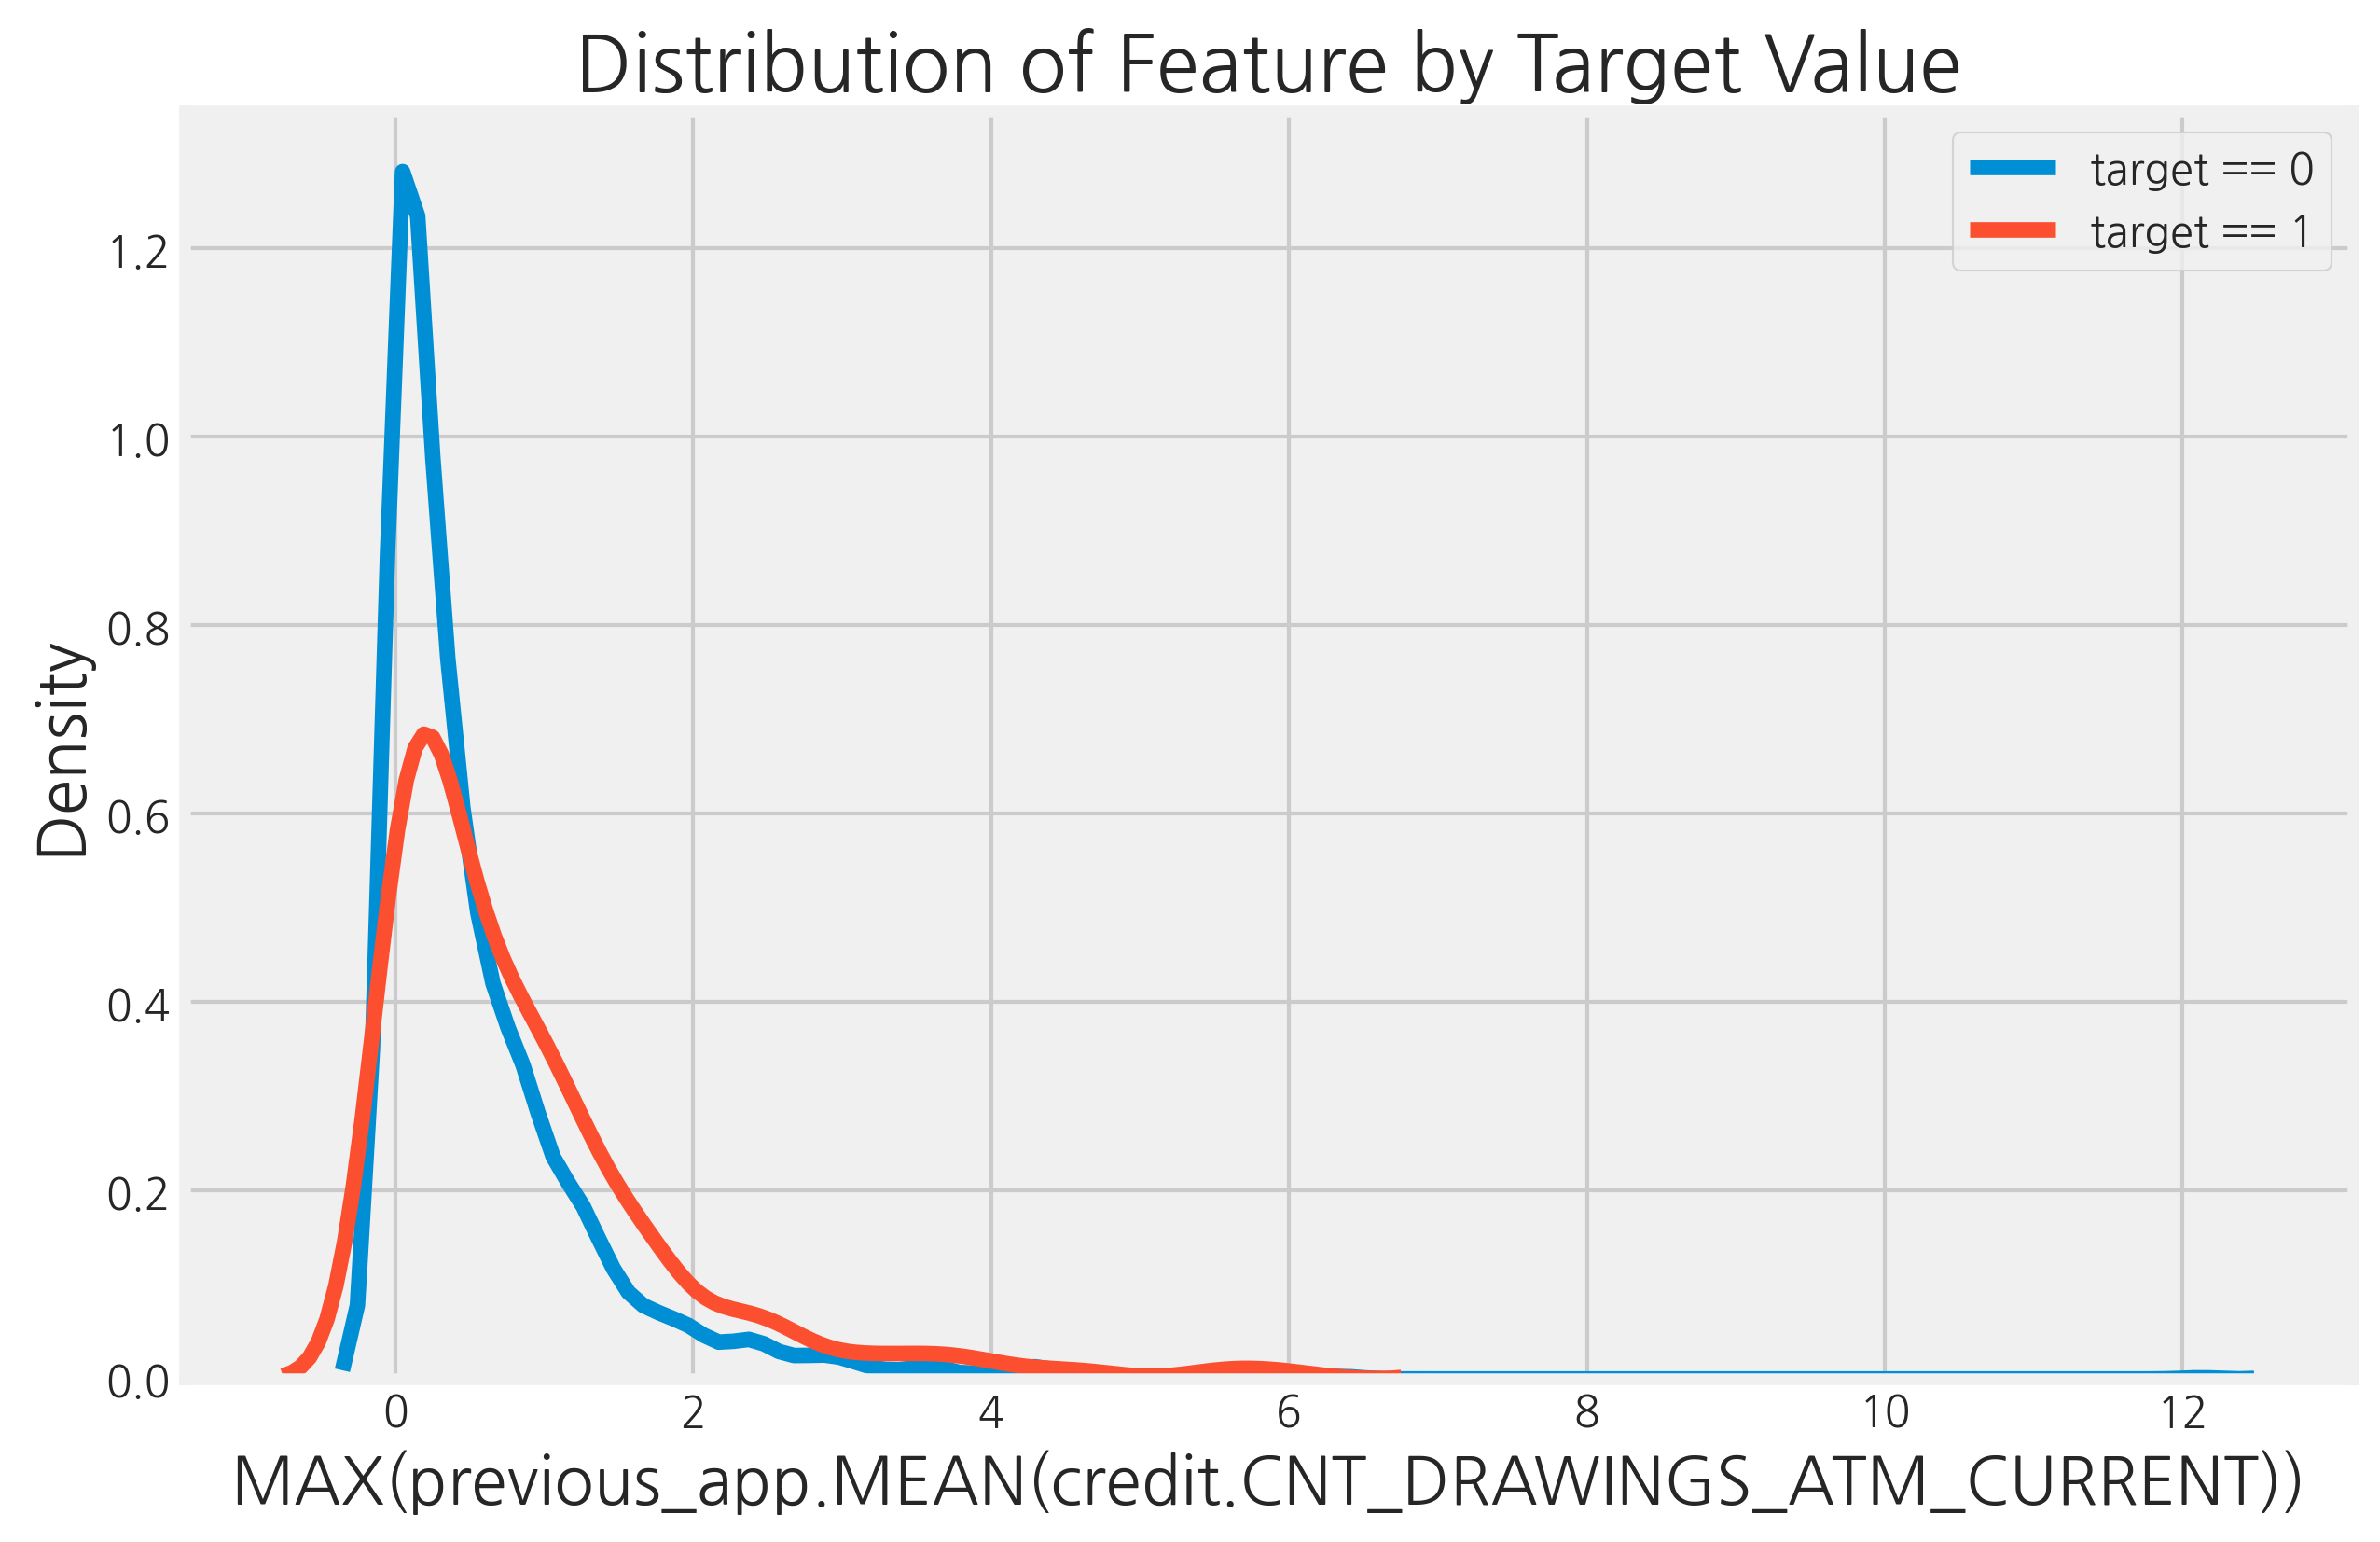

In [23]:
kde_target_plot(features_sample, feature = 'MAX(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))')

이 feature과 target 간의 상관 관계는 매우 약하며 noise일 수 있습니다. 이 feature을 해석하는 것은 어렵지만, 추측으로는 previous 신용 카드 대출에 대한 고객의 월 평균 atm 인출 횟수의 최대값입니다. (현재는 feature의 샘플만을 사용하고 있으므로 이것이 전체 데이터 세트를 대표하지 않을 수 있습니다).

조사해야 할 또 다른 영역은 collinear features로 알려진 높은 상관관계의 features입니다. correlated feateures 쌍을 찾고 , 상관관계가 threshold 이상인 features를 제거할 수 있습니다.

### Collinear Features

In [24]:
threshold = 0.9
correlated_pairs = {}

for col in correlations:
    above_threshold_vars = [x for x in list(correlations.index[correlations[col] > threshold])
                            if x != col]
    correlated_pairs[col] = above_threshold_vars

In [25]:
correlated_pairs['MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)']

['MEAN(credit.AMT_PAYMENT_CURRENT)',
 'MIN(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))',
 'MEAN(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'SUM(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'MIN(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'MEAN(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))',
 'MAX(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'MAX(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))',
 'SUM(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))']

In [26]:
correlations['MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)'].sort_values(ascending=False).head()

Variable
MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)                       1.000000
MEAN(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))    0.999382
MIN(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))     0.999024
MAX(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))     0.995957
SUM(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))     0.995484
Name: MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT), dtype: float64

Text(0.5, 1.0, 'Highly Correlated Features')

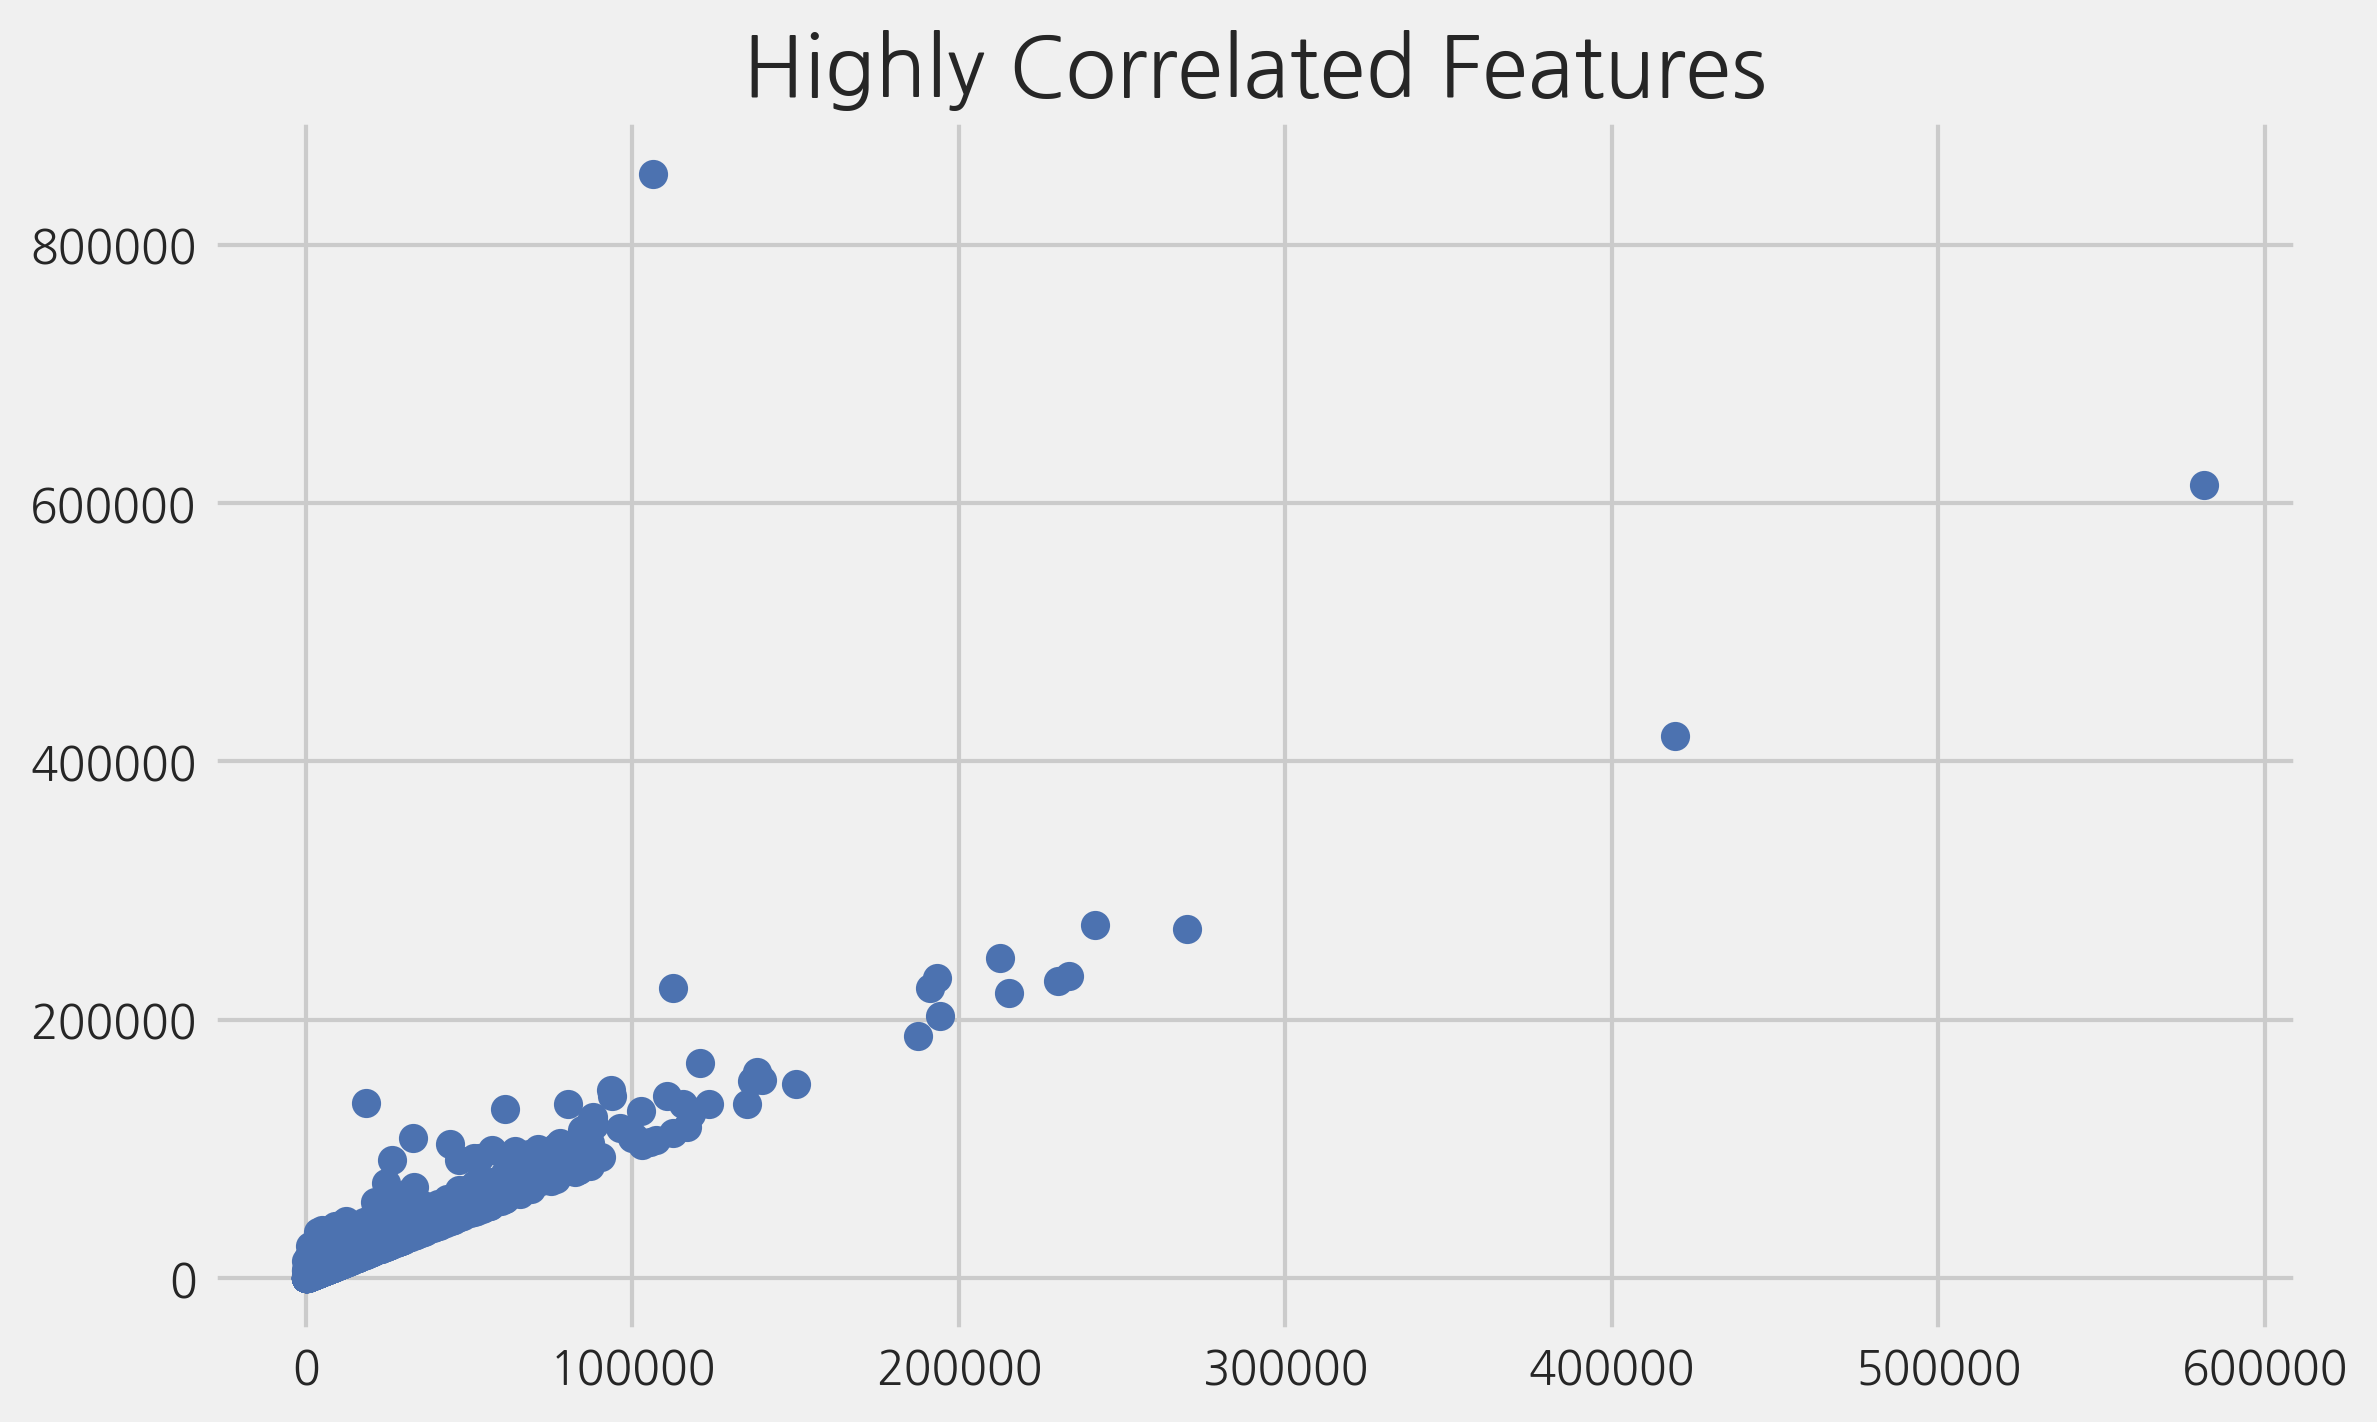

In [27]:
plt.plot(features_sample['MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)'], 
         features_sample['MEAN(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))'], 'bo')

plt.title('Highly Correlated Features')

이러한 변수는 모두 거의 완벽하게 양의 linear인 서로 0.99의 상관 관계를 갖습니다. 중복 정보를 인코딩하므로 모델에 모두 포함할 필요가 없습니다. 모델이 더 잘 학습하고 일반화하는 데 도움이 되도록 이러한 상관관계가 높은 변수 중 일부를 제거하고 싶을 것입니다.

## Feature Importances
트리 기반 모델에서 반환된 feature importances는 모델에 해당 feature을 포함함으로써 발생하는 불순물의 감소를 나타냅니다. 중요도의 절대값을 해석하기 어려울 수 있지만, 중요도의 상대값을 보면 feature의 관련성을 비교할 수 있습니다. feature importances에 너무 많은 value를 부여하는 것에 대해 주의를 기울이고 싶지만, 이는 차원 축소 및 모델 이해에 유용한 방법이 될 수 있습니다.

In [28]:
# Feature importances returned by a gradient boosting machine (using LightGBM) 
# for the features in feature_matrix_spec.csv
fi = pd.read_csv('./home_credit/spec_feature_importances_ohe.csv', 
                 index_col=0)
fi = fi.sort_values("importance", ascending=False)

fi.head(15)

feature  importance
13                                       EXT_SOURCE_1       357.6
14                                       EXT_SOURCE_3       311.6
58                                       EXT_SOURCE_2       307.0
31                                         DAYS_BIRTH       228.6
55                                         AMT_CREDIT       204.4
91                                        AMT_ANNUITY       195.2
69                                      DAYS_EMPLOYED       150.2
10                                    AMT_GOODS_PRICE       144.2
186                           MAX(bureau.DAYS_CREDIT)       138.8
42                                    DAYS_ID_PUBLISH       122.8
115                   MAX(bureau.DAYS_CREDIT_ENDDATE)       121.8
62                                        OWN_CAR_AGE       104.0
518   SUM(previous_app.MIN(installments.AMT_PAYMENT))       101.8
196                     MAX(bureau.DAYS_ENDDATE_FACT)        99.6
669  MEAN(previous_app.MIN(installments.AMT_PAYMENT))        99.0

featuretools에 의해 생성된 가장 중요한 feature은 고객이 다른 기관에서 대출을 신청한 current application까지의 최대 일수였습니다. (이 feature은 원래 음수로 기록되었으므로 최대값은 0에 가장 가깝습니다)

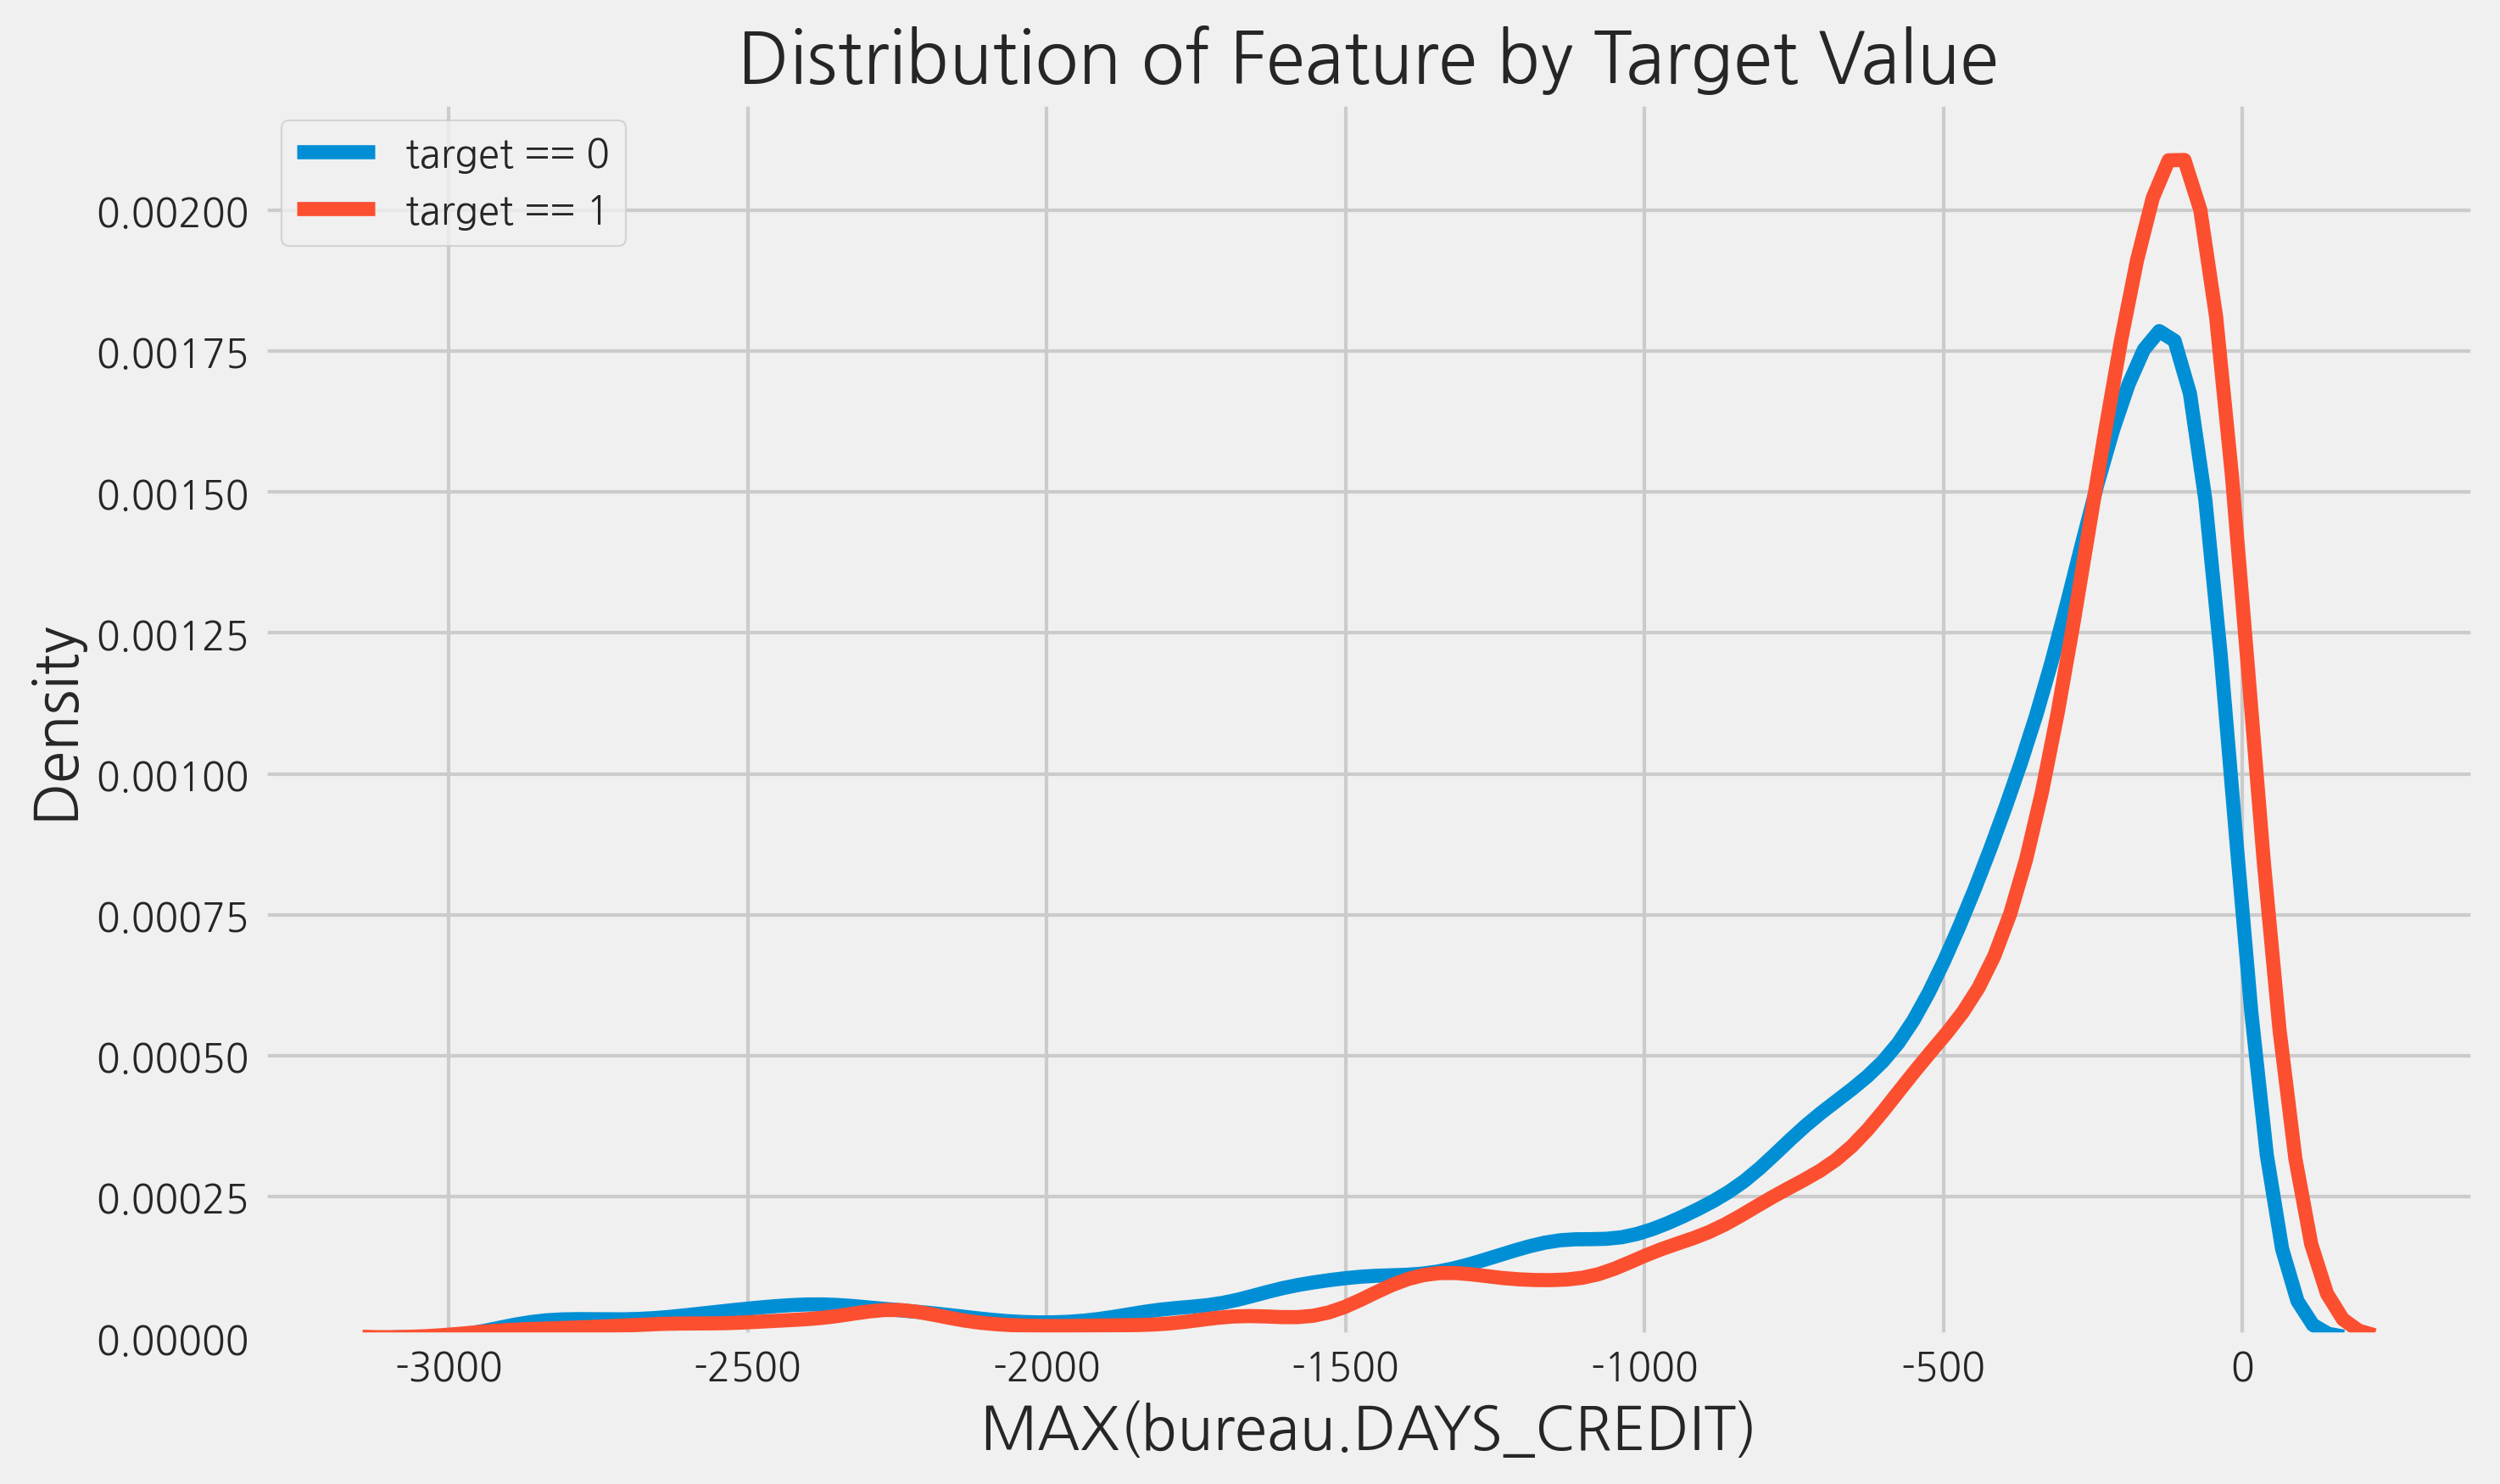

In [29]:
kde_target_plot(features_sample, feature='MAX(bureau.DAYS_CREDIT)')

우리는 featuretools에 의해 만들어진 상위 100개 feature의 수를 계산할 수 있습니다.

In [30]:
original_features = list(pd.get_dummies(app).columns)

created_features = []

for feature in fi["feature"][:100]:
    if feature not in original_features:
        created_features.append(feature)
        
print('%d of the top 100 features were made by featuretools' 
       % len(created_features))

78 of the top 100 features were made by featuretools


가장 중요한 15가지 features를 시각화하는 짧은 함수를 작성해 보겠습니다.

In [32]:
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 22

def plot_feature_importances(df):
    df = df.sort_values("importance", ascending=False).reset_index()
    df["importance_normalized"] = df["importance"] / df["importance"].sum()
    
    plt.figure(figsize=(14, 10))
    ax = plt.subplot()
    
    ax.barh(list(reversed(list(df.index[:15]))),
            df["importance_normalized"].head(15),
            align="center", edgecolor="k")
    
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df["feature"].head(15))
    
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

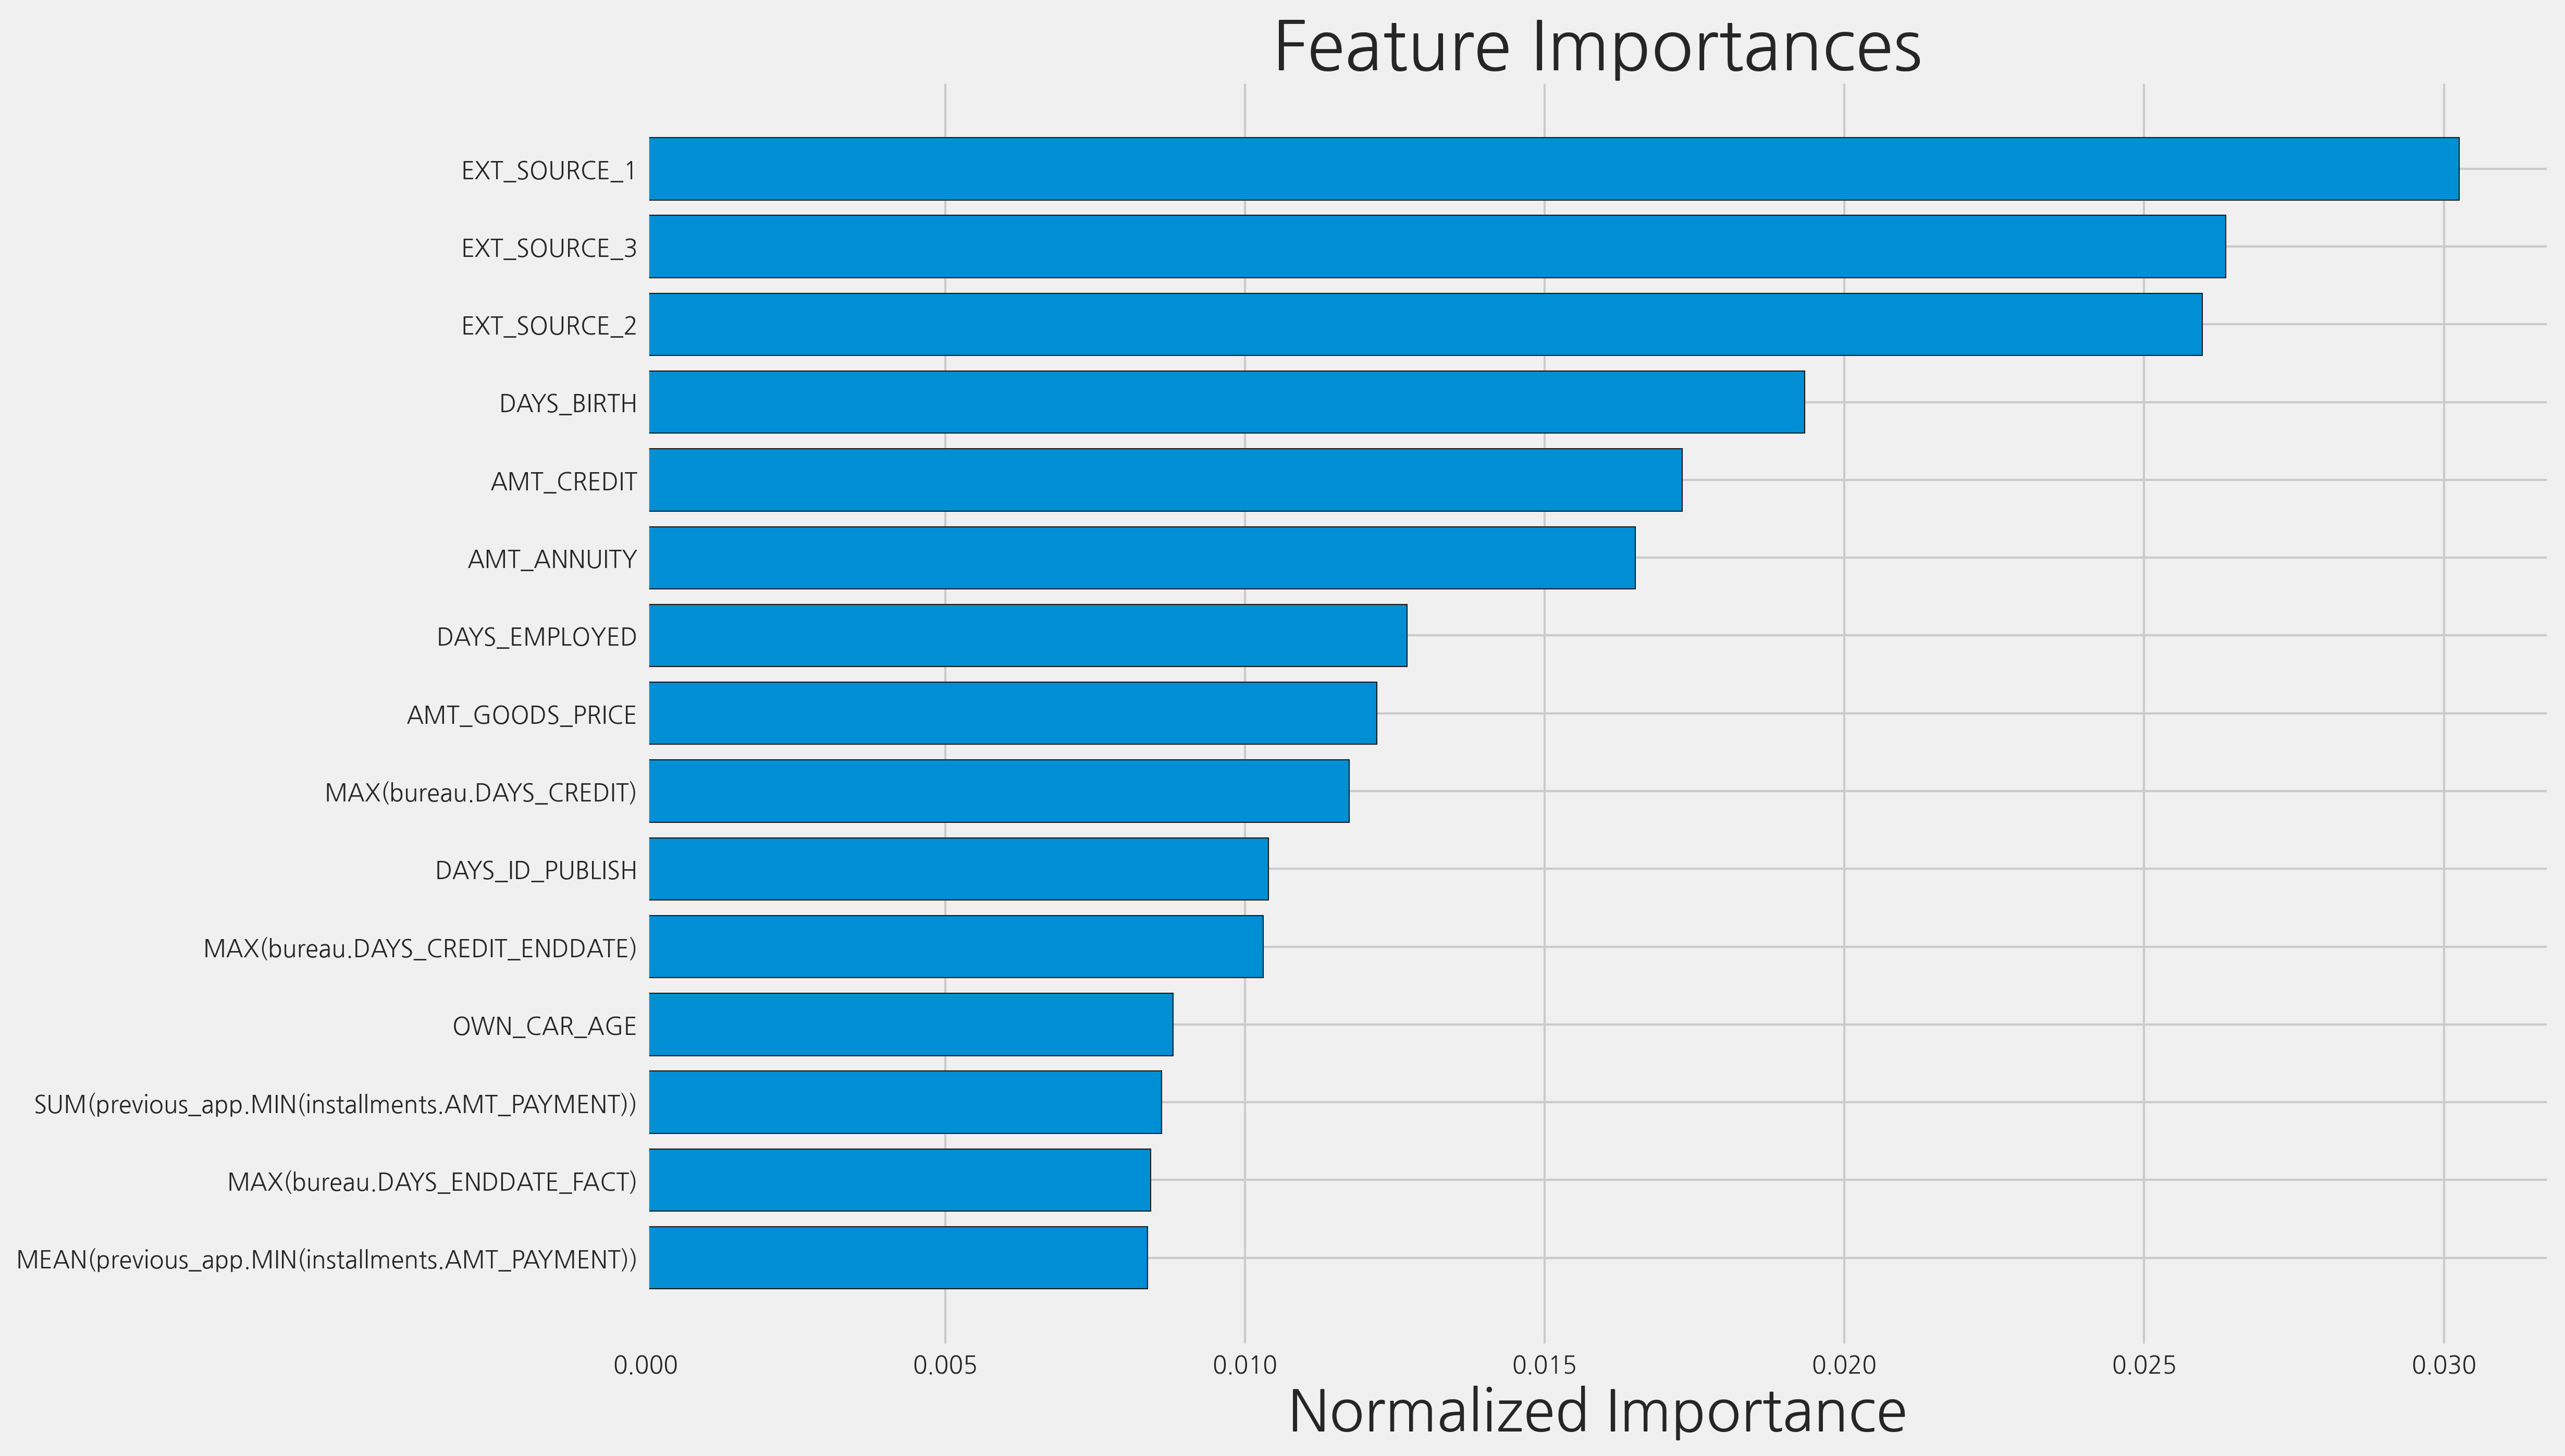

In [33]:
fi = plot_feature_importances(fi)

featuretools가 만든 가장 중요한 feature은 ```MAX(bureau.DAYS_CREDIT)```였습니다. ```DAYS_CREDIT```는 신청자가 다른 신용 기관에서 대출을 신청한 현재 Home Credit 신청 이전의 일 수를 나타냅니다. 따라서 이 값의 최대값(이전 대출 대비)이 이 feature로 표시됩니다. 또한 ```MEAN(previous_app.MIN(installments.AMT_PAYMENT))```과 같이 깊이가 2인 몇 가지 중요한 feature이 있습니다. ```MEAN(previous_app.MIN(installments.AMT_PAYMENT))```은 이전 신용 신청 할부 지불의 최소 가치에 대한 고객의 대출 평균입니다.

Feature importances는 차원 축소에 사용할 수 있습니다. 또한 문제를 더 잘 이해하는 데 도움이 될 수 있습니다. 예를 들어, 잠재적 대출을 평가할 때 클라이언트의 이러한 측면에 집중하기 위해 가장 중요한 features를 사용할 수 있습니다. featureset에서 제거할 수 있는 중요도가 0인 feature의 수를 살펴보겠습니다.

In [34]:
print('There are %d features with 0 importance' % sum(fi['importance'] == 0.0))

There are 237 features with 0 importance


## Remove Low Importance Features
Feature selection에서 우리가 할 수 있는 한 가지는 unique 값이 하나만 있거나 모두 null인 features를 제거하는 것입니다. Featuretools에는 ```selection``` 모듈에서 사용할 수 있는 default 방법이 있습니다.

In [35]:
from featuretools import selection

# unique 값이 하나이거나 모든 값이 null인 features 제거
feature_matrix2 = selection.remove_low_information_features(feature_matrix)

In [36]:
print('Removed %d features' % (feature_matrix.shape[1]- feature_matrix2.shape[1]))

Removed 369 features


## Align Train and Test Sets
우리는 또한 train과 test 세트가 정확히 동일한 features를 갖도록 하고 싶습니다. 먼저 데이터를 원-핫 인코딩(모델에 대해 이 작업을 수행해야 함)한 다음 칼럼에 데이터 프레임을 align할 수 있습니다.

In [38]:
train = feature_matrix2[feature_matrix2["set"] == "train"]
test = feature_matrix2[feature_matrix2["set"] == "test"]

train = pd.get_dummies(train)
test = pd.get_dummies(test)

train, test = train.align(test, join="inner", axis=1)
test = test.drop(columns=["TARGET"])

print('Final Training Shape: ', train.shape)
print('Final Testing Shape: ', test.shape)

Final Training Shape:  (1001, 2156)
Final Testing Shape:  (1001, 2155)


The low information features를 제거하고 데이터 프레임을 align하면 2155개의 features가 남게 됩니다. feature selection은 featuretools를 사용할 때 확실히 중요한 역할을 합니다.

# Conclusions
이 노트북에서 우리는 Home Credit Default Risk 데이터 세트에 대한 featuretools와 함께 automated feature engineering을 사용하는 기본 구현을 살펴보았습니다. 여기서는 featuretools의 고급 기능을 사용하지 않았지만 cross validation 및 테스트 세트에서 모델의 성능을 향상시키는 유용한 features를 만들 수 있었습니다. 또한, automated feature engineering은 유사한 결과를 제공하면서 manual feature engineering에 소요되는 시간의 일부만 사용했습니다.

featuretools의 기본 featuretools도 10% 미만의 시간으로 hand-engineered features와 유사한 성능을 달성할 수 있었습니다.

## Appendix: GBM Model (Used Across Feature Sets)

In [39]:
def model(features, test_features, encoding='ohe', n_folds=5):
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']

    labels = features['TARGET']

    features = features.drop(columns=['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns=['SK_ID_CURR'])


    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)

        features, test_features = features.align(test_features, join='inner', axis=1)

        # No categorical indices to record
        cat_indices = 'auto'

    # Integer label encoding
    elif encoding == 'le':

        label_encoder = LabelEncoder()

        cat_indices = []

        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                cat_indices.append(i)

    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")

    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)

    feature_names = list(features.columns)

    features = np.array(features)
    test_features = np.array(test_features)

    k_fold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=50)

    feature_importance_values = np.zeros(len(feature_names))

    test_predictions = np.zeros(test_features.shape[0])

    out_of_fold = np.zeros(features.shape[0])

    valid_scores = []
    train_scores = []

    for train_indices, valid_indices in k_fold.split(features, labels):

        train_features, train_labels = features[train_indices], labels[train_indices]
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]

        model = lgb.LGBMClassifier(n_estimators=10000, boosting_type='goss',
                                   objective='binary', 
                                   class_weight='balanced', learning_rate=0.05, 
                                   reg_alpha=0.1, reg_lambda=0.1, n_job =-1, random_state = 50)

        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set=[(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names=['valid', 'train'], categorical_feature=cat_indices,
                  early_stopping_rounds=100, verbose=200)

        best_iteration = model.best_iteration_

        feature_importance_values += model.feature_importances_ / k_fold.n_splits

        test_predictions += model.predict_proba(test_features, num_iteration=best_iteration)[:, 1] / k_fold.n_splits

        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration=best_iteration)[:, 1]

        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']

        valid_scores.append(valid_score)
        train_scores.append(train_score)

        gc.enable()
        del model, train_features, valid_features
        gc.collect()

    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})

    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    valid_auc = roc_auc_score(labels, out_of_fold)

    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))

    fold_names = list(range(n_folds))
    fold_names.append('overall')

    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 

    return submission, feature_importances, metrics